# Group E: AML Project

This project aims to use regression to build a prediction model that colorizes grayscale images. We use linear regression (using gradient descent), SVR, Neural Network baseline model, and Neural Network U-net model. Since the official imagenet dataset is extemely large, we use the tiny-imagenet dataset from Kaggle, which includes a smaller subset of the orignial dataset.

**Dataset:** https://www.kaggle.com/datasets/akash2sharma/tiny-imagenet


# Table of Content
### 1. Setup and Dataloading
- import libraries
- load datasets
### 2. Linear/SVR: Preprocess Data
- Turn RBG to L chanel
- Identity X (L channel) and Y (a/b channel)
- Scale Data
### 3. Linear/SVR: PCA
- Apply PCA on X training data
### 4. Linear/SVR: Apply Model
- ThunderstormSVM, which utilizes GPU will be used to speed the model
### 5. Linear/SVR: Check Accuracy:
- MSE
- R^2
- SSIM
- PSNR
### Neural Network:
### 6. Import Libraries
### 7. Identify ColorizationDataset
### 8. Apply Baseline model
### 9. Apply U-Net Model


## 1.1 Download Data

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ziwei1020zhang","key":"e0080628721fe9800523f38125931d37"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d akash2sharma/tiny-imagenet

!unzip tiny-imagenet.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/tiny-imagenet-200/val/images/val_5500.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5501.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5502.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5503.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5504.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5505.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5506.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5507.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5508.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5509.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_551.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5510.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5511.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5512.JPEG  
  inflating:

In [ ]:
import glob

train_dir = "/content/tiny-imagenet-200/train"
train_files = glob.glob(train_dir + "/**/*.[jJ][pP][eE][gG]", recursive=True)

print("Number of images:", len(train_files))
print(train_files[:5])

val_dir = "/content/tiny-imagenet-200/val/images/"
val_files = glob.glob(val_dir + "/**/*.[jJ][pP][eE][gG]", recursive=True)

print("Number of images:", len(val_files))
print(val_files[:5])

test_dir = "/content/tiny-imagenet-200/test/images/"
test_files = glob.glob(test_dir + "/**/*.[jJ][pP][eE][gG]", recursive=True)

print("Number of images:", len(test_files))
print(test_files[:5])

Number of images: 100000
['/content/tiny-imagenet-200/train/n07734744/images/n07734744_260.JPEG', '/content/tiny-imagenet-200/train/n07734744/images/n07734744_150.JPEG', '/content/tiny-imagenet-200/train/n07734744/images/n07734744_226.JPEG', '/content/tiny-imagenet-200/train/n07734744/images/n07734744_46.JPEG', '/content/tiny-imagenet-200/train/n07734744/images/n07734744_222.JPEG']
Number of images: 10000
['/content/tiny-imagenet-200/val/images/val_7859.JPEG', '/content/tiny-imagenet-200/val/images/val_4132.JPEG', '/content/tiny-imagenet-200/val/images/val_8501.JPEG', '/content/tiny-imagenet-200/val/images/val_972.JPEG', '/content/tiny-imagenet-200/val/images/val_1414.JPEG']
Number of images: 10000
['/content/tiny-imagenet-200/test/images/test_2471.JPEG', '/content/tiny-imagenet-200/test/images/test_7486.JPEG', '/content/tiny-imagenet-200/test/images/test_7416.JPEG', '/content/tiny-imagenet-200/test/images/test_5967.JPEG', '/content/tiny-imagenet-200/test/images/test_1278.JPEG']


# Linear and SVM

## 1.2 Import Libraries (SVM)

In [ ]:
import os
import numpy as np
from skimage.color import rgb2lab, lab2rgb
from skimage.io import imread
from skimage.transform import resize
from sklearn.decomposition import PCA
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import random
from sklearn.multioutput import MultiOutputRegressor
import torch
import torch.nn as nn
import torchvision.transforms as T
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import torch.optim as optim
from skimage.metrics import structural_similarity as ssim_metric
from skimage.metrics import peak_signal_noise_ratio as psnr_metric


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on:", device)

Running on: cuda


In [ ]:
# This is to install cuda-9.0 for thundersvm to run

!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls  # Check if required cuda 9.0 amd64-deb file is downloaded
!dpkg -i cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls /var/cuda-repo-9-0-local | grep .pub
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!sudo apt-get install cuda-9.0

--2025-12-08 23:19:20--  https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
Resolving developer.nvidia.com (developer.nvidia.com)... 184.25.123.4, 184.25.123.28, 184.25.123.27, ...
Connecting to developer.nvidia.com (developer.nvidia.com)|184.25.123.4|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://developer.nvidia.com/downloads/compute/cuda/9.0/prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb [following]
--2025-12-08 23:19:21--  https://developer.nvidia.com/downloads/compute/cuda/9.0/prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
Reusing existing connection to developer.nvidia.com:443.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://developer.download.nvidia.com/compute/cuda/9.0/secure/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64.deb?__token__=exp=1765237761~hmac=

In [ ]:
!pip install thundersvm

from thundersvm import SVR
from skimage.metrics import structural_similarity as ssim


## 2.0 Preprocess Dataset

The goal of the model is to predict A and B channels from the L channel (L --> a, b) of images with Support Vector Regression. In order to prepare the dataset, L,A,B channel is extracted from each image. To expediate comuputation, image size are reduced to 28*28. The dataset already has separate train and test set, so splitting the data is skipped. Then the dataset is scaled.

- L (Lightness): Contains only grayscale information (0 = black, 100 = white).
Used as the model’s input “black-and-white” representation.

- a channel: Represents the green–red color axis (−128 to +127).

- b channel: Represents the blue–yellow color axis (−128 to +127).

(2000, 784) (2000, 784) (2000, 784) (2000, 1568) (1000, 784)


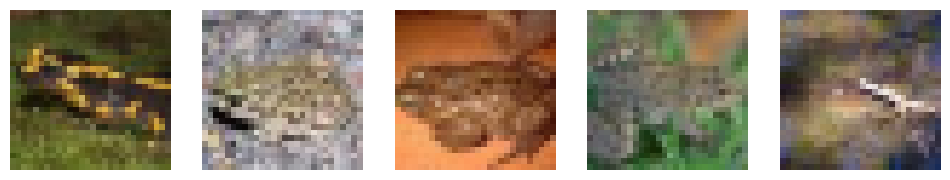

In [ ]:
###################### Change number of train and test set here
train_num_images = 2000 #100000
test_num_images = 1000
val_num_images = 1000

#PCA number of components
k = 300 #600 at lr

pixel = 28 #64 or 28
pixels = pixel * pixel  # 784
#######################


class LABDataset(Dataset):
    def __init__(self, folder_path):
        self.folder = folder_path

        # Recursively find all JPEG images
        self.files = sorted(
            glob.glob(os.path.join(folder_path, "**", "*.JPEG"), recursive=True) +
            glob.glob(os.path.join(folder_path, "**", "*.jpeg"), recursive=True)
        )

        # Grayscale transform for L-channel input later (if needed)
        self.gray_transform = T.Compose([
            T.Resize((pixel, pixel)),
            T.Grayscale(num_output_channels=1),
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]

        # Load RGB image
        img = imread(path)
        if img.ndim == 2:
            img = np.stack([img]*3, axis=-1)

        # Resize from 64,64 --> 28,28
        ############################## Resized image to be smaller for fast computation
        img_resized = resize(img, (pixel, pixel), anti_aliasing=True)

        # Convert to Lab
        lab = rgb2lab(img_resized)

        L = lab[:, :, 0].flatten()
        a = lab[:, :, 1].flatten()
        b = lab[:, :, 2].flatten()

        return L, a, b

train_dir = "/content/tiny-imagenet-200/train"
val_dir = "/content/tiny-imagenet-200/val/images"
test_dir = "/content/tiny-imagenet-200/test/images"
traindataset = LABDataset(train_dir)
testdataset = LABDataset(test_dir)
valdataset = LABDataset(val_dir)


########

X_train_list = []
a_train_list = []
b_train_list = []

X_test_list = []
a_test_list = []
b_test_list = []

X_val_list = []
a_val_list = []
b_val_list = []

for i in range(train_num_images):
    X, a, b = traindataset[i]
    X_train_list.append(X)
    a_train_list.append(a)
    b_train_list.append(b)

X_train = np.array(X_train_list)
y_train_a = np.array(a_train_list)
y_train_b = np.array(b_train_list)
y_train = np.concatenate([y_train_a, y_train_b], axis=1)

for i in range(test_num_images):
    L, a, b = testdataset[i]
    X_test_list.append(L)
    a_test_list.append(a)
    b_test_list.append(b)

X_test = np.array(X_test_list)
y_test_a = np.array(a_test_list)
y_test_b = np.array(b_test_list)
y_test = np.concatenate([y_test_a, y_test_b], axis=1)

for i in range(val_num_images):
    L, a, b = valdataset[i]
    X_val_list.append(L)
    a_val_list.append(a)
    b_val_list.append(b)

X_val = np.array(X_val_list)
y_val_a = np.array(a_val_list)
y_val_b = np.array(b_val_list)
y_val = np.concatenate([y_val_a, y_val_b], axis=1)

print(X_train.shape, y_train_a.shape, y_train_b.shape, y_train.shape, X_test.shape)

#############
# visualize
sample_ids = random.sample(range(train_num_images), 5)

plt.figure(figsize=(12, 5))
for i, idx in enumerate(sample_ids):
    L = X_train[idx].reshape(pixel,pixel)
    a = y_train_a[idx].reshape(pixel,pixel)
    b = y_train_b[idx].reshape(pixel,pixel)

    # Stack back to Lab
    lab_img = np.stack([L, a, b], axis=2)

    # Convert Lab → RGB
    rgb = lab2rgb(lab_img)

    # Plot
    plt.subplot(1, 5, i+1)
    plt.imshow(rgb)
    plt.axis("off")

plt.show()

#############
# Convert to tensors and scale
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test  = torch.tensor(X_test, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_torch = torch.tensor(y_val, dtype=torch.float32).to(device)

mean = X_train.mean(0, keepdim=True)
std  = X_train.std(0, keepdim=True)

X_train_scale = (X_train - mean) / std
X_test_scale  = (X_test - mean) / std
X_val_scale = (X_val - mean) / std

## 3.0 PCA (n=500)

PCA is implemented to decrease dimensionality of the input before training the model. In order to speed up the process, PyTorch PCA package, which runs on GPU, is used instead of the standard scikitlearn PCA package. Number of components is 500.


torch.Size([2000, 300]) torch.Size([1000, 300])


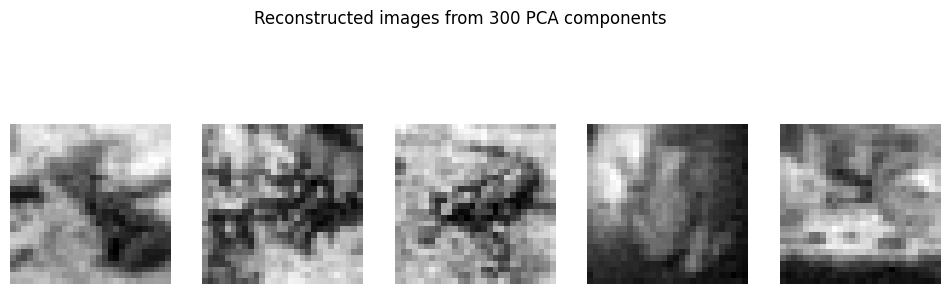

In [ ]:
# PCA

#k = 4000

U,S,V = torch.pca_lowrank(X_train_scale, center=False, q=k) #Center=false bc data is scaled

X_train_pca = X_train @ V[:, :k]
X_test_pca  = X_test  @ V[:, :k]
X_val_pca = X_val @ V[:, :k]

# Check the shape after PCA
print(X_train_pca.shape, X_test_pca.shape)

# Visualize PCA training set
idxs = random.sample(range(X_train_pca.shape[0]), 5)
X_recon_scaled = X_train_pca[idxs] @ V[:, :k].T
X_recon = X_recon_scaled * std + mean
X_recon = X_recon.cpu().numpy()
X_recon_imgs = X_recon.reshape(-1, pixel, pixel)

plt.figure(figsize=(12, 4))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_recon_imgs[i], cmap='gray')
    plt.axis('off')

plt.suptitle(f"Reconstructed images from {k} PCA components")
plt.show()

## 4.1 Apply Model: Linear Regression (Gradient Descent)

Parameters:
- Learning rate: 0.001
- Number of epochs: 100
- Optimizer type: Adam
- Loss Function: MSE loss
- Regularization: L2 regularization
- Batch size: full


In [ ]:
y_train_torch = torch.tensor(y_train, dtype=torch.float32).to(device)  # (N_train, 2*pixels)
y_val_torch   = torch.tensor(y_val,   dtype=torch.float32).to(device)  # (N_val,   2*pixels)
y_test_torch  = torch.tensor(y_test,  dtype=torch.float32).to(device)  # (N_test,  2*pixels)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32).to(device)

# ===========================================================
# Linear regression model: y = XW + b
# ===========================================================
in_dim  = k
out_dim = 2 * pixels   # predict flattened a and b channels

class LinearColorizer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        return self.linear(x)

model = LinearColorizer(in_dim, out_dim).to(device)

# Hyperparameters
learning_rate = 0.001
num_epochs    = 100
weight_decay  = 1e-4   # L2 regularization strength (you can tune this)

criterion  = nn.MSELoss()
optimizer  = torch.optim.Adam(model.parameters(),
                              lr=learning_rate,
                              weight_decay=weight_decay)  # L2

# ===========================================================
# Training loop (full batch) + validation metrics (MSE, SSIM, PSNR)
# ===========================================================
train_loss_history = []
val_loss_history   = []
val_ssim_history   = []
val_psnr_history   = []

N_val = X_val.shape[0]

for epoch in range(num_epochs):
    # ---- Train step (full batch) ----
    model.train()
    optimizer.zero_grad()

    y_pred_train = model(X_train_pca)            # (N_train, out_dim)
    train_loss   = criterion(y_pred_train, y_train_torch)

    train_loss.backward()
    optimizer.step()

    # ---- Validation step ----
    model.eval()
    with torch.no_grad():
        y_pred_val = model(X_val_pca)           # (N_val, out_dim)
        val_loss   = criterion(y_pred_val, y_val_torch)

        # Move to CPU for metric computation
        L_val_np        = X_val.cpu().numpy()               # (N_val, pixels)
        y_val_true_np   = y_val_torch.cpu().numpy()         # (N_val, 2*pixels)
        y_val_pred_np   = y_pred_val.cpu().numpy()          # (N_val, 2*pixels)

        ssim_sum = 0.0
        psnr_sum = 0.0

        for i in range(N_val):
            # L channel is the same for true and pred (we're not changing L)
            L_img = L_val_np[i].reshape(pixel, pixel)

            # True a,b
            a_true = y_val_true_np[i, :pixels].reshape(pixel, pixel)
            b_true = y_val_true_np[i, pixels:].reshape(pixel, pixel)

            # Predicted a,b
            a_pred = y_val_pred_np[i, :pixels].reshape(pixel, pixel)
            b_pred = y_val_pred_np[i, pixels:].reshape(pixel, pixel)

            # Build Lab images
            lab_true = np.stack([L_img, a_true, b_true], axis=2)
            lab_pred = np.stack([L_img, a_pred, b_pred], axis=2)

            # Convert to RGB in [0,1]
            rgb_true = lab2rgb(lab_true)
            rgb_pred = lab2rgb(lab_pred)

            # Compute SSIM & PSNR on RGB
            ssim_val = ssim_metric(
                rgb_true, rgb_pred,
                channel_axis=-1,
                data_range=1.0
            )
            psnr_val = psnr_metric(
                rgb_true, rgb_pred,
                data_range=1.0
            )

            ssim_sum += ssim_val
            psnr_sum += psnr_val

        mean_ssim = ssim_sum / N_val
        mean_psnr = psnr_sum / N_val

    # Store history
    train_loss_history.append(train_loss.item())
    val_loss_history.append(val_loss.item())
    val_ssim_history.append(mean_ssim)
    val_psnr_history.append(mean_psnr)

    if (epoch + 1) % 5 == 0 or (epoch + 1) == num_epochs:
      print(f"Epoch {epoch+1:3d}/{num_epochs} | "
          f"Train MSE: {train_loss.item():.4f} | "
          f"Val MSE: {val_loss.item():.4f} | "
          f"Val SSIM: {mean_ssim:.4f} | "
          f"Val PSNR: {mean_psnr:.2f} dB")

/tmp/ipython-input-4077867561.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_t  = torch.tensor(X_test,  dtype=torch.float32).to(device)
/tmp/ipython-input-4077867561.py:85: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 52 negative Z values that have been clipped to zero
  rgb_pred = lab2rgb(lab_pred)
/tmp/ipython-input-4077867561.py:85: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 34 negative Z values that have been clipped to zero
  rgb_pred = lab2rgb(lab_pred)
/tmp/ipython-input-4077867561.py:85: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2 negative Z values that have been clipped to zero
  rgb_pred = lab2rgb(lab_pred)
/tmp/ipython-input-4077867561.py:85: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resu

Epoch   5/100 | Train MSE: 620.7119 | Val MSE: 525.2249 | Val SSIM: 0.6481 | Val PSNR: 17.82 dB


/tmp/ipython-input-4077867561.py:85: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 529 negative Z values that have been clipped to zero
  rgb_pred = lab2rgb(lab_pred)
/tmp/ipython-input-4077867561.py:85: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 243 negative Z values that have been clipped to zero
  rgb_pred = lab2rgb(lab_pred)
/tmp/ipython-input-4077867561.py:85: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 609 negative Z values that have been clipped to zero
  rgb_pred = lab2rgb(lab_pred)
/tmp/ipython-input-4077867561.py:85: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 204 negative Z values that have been clipped to zero
  rgb_pred = lab2rgb(lab_pred)
/tmp/ipython-input-4077867561.py:85: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 189 negative Z values that have been clipped to zero
  rgb_pred = lab2rgb(lab_pred)
/tmp/

Epoch  10/100 | Train MSE: 366.5618 | Val MSE: 346.1840 | Val SSIM: 0.7637 | Val PSNR: 20.29 dB


/tmp/ipython-input-4077867561.py:85: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 274 negative Z values that have been clipped to zero
  rgb_pred = lab2rgb(lab_pred)
/tmp/ipython-input-4077867561.py:85: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 342 negative Z values that have been clipped to zero
  rgb_pred = lab2rgb(lab_pred)
/tmp/ipython-input-4077867561.py:85: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 199 negative Z values that have been clipped to zero
  rgb_pred = lab2rgb(lab_pred)
/tmp/ipython-input-4077867561.py:85: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 136 negative Z values that have been clipped to zero
  rgb_pred = lab2rgb(lab_pred)
/tmp/ipython-input-4077867561.py:85: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 145 negative Z values that have been clipped to zero
  rgb_pred = lab2rgb(lab_pred)
/tmp/

Epoch  15/100 | Train MSE: 333.2071 | Val MSE: 323.5505 | Val SSIM: 0.7916 | Val PSNR: 20.81 dB


/tmp/ipython-input-4077867561.py:85: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 353 negative Z values that have been clipped to zero
  rgb_pred = lab2rgb(lab_pred)
/tmp/ipython-input-4077867561.py:85: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 255 negative Z values that have been clipped to zero
  rgb_pred = lab2rgb(lab_pred)
/tmp/ipython-input-4077867561.py:85: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 190 negative Z values that have been clipped to zero
  rgb_pred = lab2rgb(lab_pred)
/tmp/ipython-input-4077867561.py:85: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 478 negative Z values that have been clipped to zero
  rgb_pred = lab2rgb(lab_pred)
/tmp/ipython-input-4077867561.py:85: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 777 negative Z values that have been clipped to zero
  rgb_pred = lab2rgb(lab_pred)
/tmp/

Epoch  20/100 | Train MSE: 307.5055 | Val MSE: 298.9220 | Val SSIM: 0.8190 | Val PSNR: 21.24 dB


/tmp/ipython-input-4077867561.py:85: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 244 negative Z values that have been clipped to zero
  rgb_pred = lab2rgb(lab_pred)
/tmp/ipython-input-4077867561.py:85: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 188 negative Z values that have been clipped to zero
  rgb_pred = lab2rgb(lab_pred)
/tmp/ipython-input-4077867561.py:85: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 404 negative Z values that have been clipped to zero
  rgb_pred = lab2rgb(lab_pred)
/tmp/ipython-input-4077867561.py:85: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 629 negative Z values that have been clipped to zero
  rgb_pred = lab2rgb(lab_pred)
/tmp/ipython-input-4077867561.py:85: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 245 negative Z values that have been clipped to zero
  rgb_pred = lab2rgb(lab_pred)
/tmp/

Epoch  25/100 | Train MSE: 275.5493 | Val MSE: 272.4869 | Val SSIM: 0.8505 | Val PSNR: 21.75 dB


/tmp/ipython-input-4077867561.py:85: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 235 negative Z values that have been clipped to zero
  rgb_pred = lab2rgb(lab_pred)
/tmp/ipython-input-4077867561.py:85: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 401 negative Z values that have been clipped to zero
  rgb_pred = lab2rgb(lab_pred)
/tmp/ipython-input-4077867561.py:85: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 241 negative Z values that have been clipped to zero
  rgb_pred = lab2rgb(lab_pred)
/tmp/ipython-input-4077867561.py:85: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 362 negative Z values that have been clipped to zero
  rgb_pred = lab2rgb(lab_pred)
/tmp/ipython-input-4077867561.py:85: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 309 negative Z values that have been clipped to zero
  rgb_pred = lab2rgb(lab_pred)
/tmp/

Epoch  30/100 | Train MSE: 256.4471 | Val MSE: 258.2741 | Val SSIM: 0.8712 | Val PSNR: 22.11 dB


/tmp/ipython-input-4077867561.py:85: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 184 negative Z values that have been clipped to zero
  rgb_pred = lab2rgb(lab_pred)


Epoch  35/100 | Train MSE: 248.0600 | Val MSE: 251.4539 | Val SSIM: 0.8841 | Val PSNR: 22.35 dB
Epoch  40/100 | Train MSE: 242.6559 | Val MSE: 246.1308 | Val SSIM: 0.8958 | Val PSNR: 22.53 dB
Epoch  45/100 | Train MSE: 238.3482 | Val MSE: 241.9135 | Val SSIM: 0.9066 | Val PSNR: 22.66 dB
Epoch  50/100 | Train MSE: 235.5837 | Val MSE: 239.3524 | Val SSIM: 0.9142 | Val PSNR: 22.73 dB
Epoch  55/100 | Train MSE: 234.0121 | Val MSE: 237.9333 | Val SSIM: 0.9189 | Val PSNR: 22.77 dB
Epoch  60/100 | Train MSE: 233.0020 | Val MSE: 237.0315 | Val SSIM: 0.9217 | Val PSNR: 22.80 dB
Epoch  65/100 | Train MSE: 232.3181 | Val MSE: 236.4472 | Val SSIM: 0.9235 | Val PSNR: 22.83 dB
Epoch  70/100 | Train MSE: 231.8837 | Val MSE: 236.0988 | Val SSIM: 0.9248 | Val PSNR: 22.85 dB
Epoch  75/100 | Train MSE: 231.6201 | Val MSE: 235.8962 | Val SSIM: 0.9257 | Val PSNR: 22.86 dB
Epoch  80/100 | Train MSE: 231.4488 | Val MSE: 235.7605 | Val SSIM: 0.9263 | Val PSNR: 22.86 dB
Epoch  85/100 | Train MSE: 231.3351 | Va

### 4.1.1 Train vs Validation


=== Test set metrics ===
Test MSE : 235.9506
Test R²  : -0.0367
Test SSIM: 0.9287
Test PSNR: 23.08 dB


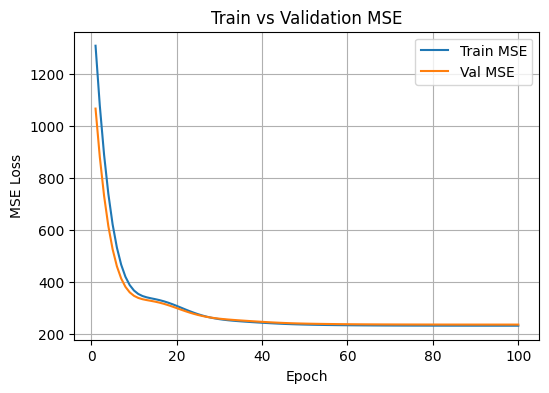

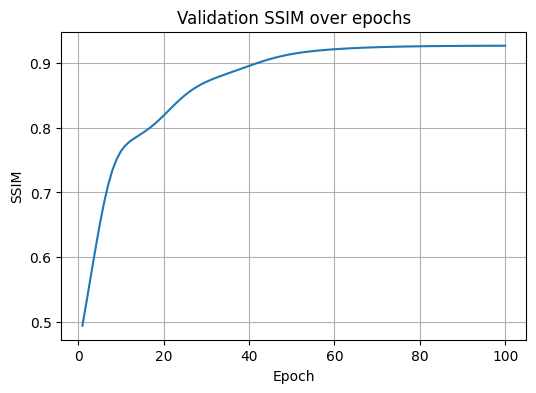

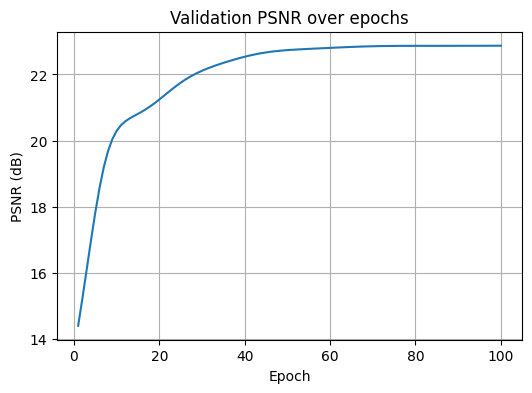

In [ ]:
def r2_score_torch(y_true, y_pred):
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - y_true.mean(dim=0, keepdim=True)) ** 2)
    return 1 - ss_res / ss_tot

####

model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_pca)
    test_mse = criterion(y_pred_test, y_test_torch).item()
    test_r2 = r2_score_torch(y_test_torch, y_pred_test).item()

    L_test_np      = X_test.cpu().numpy()
    y_test_true_np = y_test_torch.cpu().numpy()
    y_test_pred_np = y_pred_test.cpu().numpy()

    ssim_sum = 0.0
    psnr_sum = 0.0
    N_test   = X_test.shape[0]

    for i in range(N_test):
        L_img = L_test_np[i].reshape(pixel, pixel)
        a_true = y_test_true_np[i, :pixels].reshape(pixel, pixel)
        b_true = y_test_true_np[i, pixels:].reshape(pixel, pixel)

        a_pred = y_test_pred_np[i, :pixels].reshape(pixel, pixel)
        b_pred = y_test_pred_np[i, pixels:].reshape(pixel, pixel)

        lab_true = np.stack([L_img, a_true, b_true], axis=2)
        lab_pred = np.stack([L_img, a_pred, b_pred], axis=2)

        rgb_true = lab2rgb(lab_true)
        rgb_pred = lab2rgb(lab_pred)

        ssim_val = ssim_metric(
            rgb_true, rgb_pred,
            channel_axis=-1,
            data_range=1.0
        )
        psnr_val = psnr_metric(
            rgb_true, rgb_pred,
            data_range=1.0
        )

        ssim_sum += ssim_val
        psnr_sum += psnr_val

    test_ssim = ssim_sum / N_test
    test_psnr = psnr_sum / N_test

print("\n=== Test set metrics ===")
print(f"Test MSE : {test_mse:.4f}")
print(f"Test R²  : {test_r2:.4f}")
print(f"Test SSIM: {test_ssim:.4f}")
print(f"Test PSNR: {test_psnr:.2f} dB")

# ===========================================================
# Plots: train vs val MSE, SSIM curve, PSNR curve
# ===========================================================
epochs_range = range(1, num_epochs + 1)

# 1) Train vs Val MSE
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, train_loss_history, label="Train MSE")
plt.plot(epochs_range, val_loss_history,   label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train vs Validation MSE")
plt.legend()
plt.grid(True)
plt.show()

# 2) SSIM curve (validation)
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, val_ssim_history)
plt.xlabel("Epoch")
plt.ylabel("SSIM")
plt.title("Validation SSIM over epochs")
plt.grid(True)
plt.show()

# 3) PSNR curve (validation)
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, val_psnr_history)
plt.xlabel("Epoch")
plt.ylabel("PSNR (dB)")
plt.title("Validation PSNR over epochs")
plt.grid(True)
plt.show()

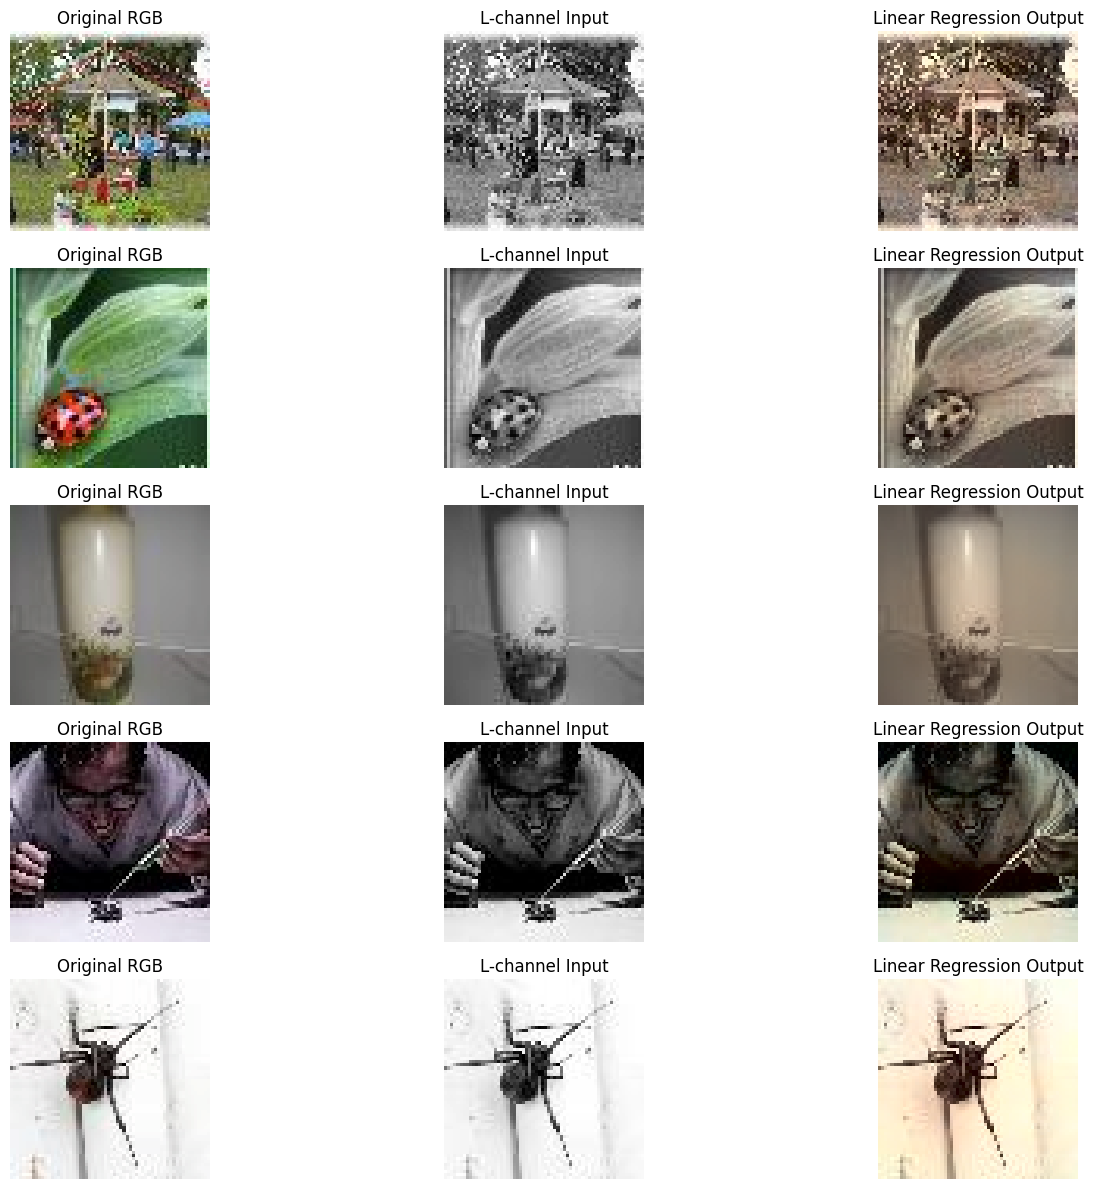

In [ ]:

def lab_to_rgb(L_flat, a_flat, b_flat):
    L = L_flat.reshape(pixel, pixel).clip(0, 100)
    a = a_flat.reshape(pixel, pixel).clip(-128, 127)
    b = b_flat.reshape(pixel, pixel).clip(-128, 127)
    lab = np.stack([L, a, b], axis=2)
    return lab2rgb(lab)

# Convert tensors to numpy
lrpred_test_np = y_pred_test.cpu().numpy()
X_test_np      = X_test_t.cpu().numpy()
y_test_np      = y_test_torch.cpu().numpy()

# Pick 5 random test indices
indices = np.random.choice(X_test_np.shape[0], 5, replace=False)

plt.figure(figsize=(15, 12))

for i, idx in enumerate(indices):

    # ---- TRUE IMAGE ----
    true_L = X_test_np[idx]
    true_a = y_test_np[idx][:pixels]
    true_b = y_test_np[idx][pixels:]
    original_rgb = lab_to_rgb(true_L, true_a, true_b)

    # L-channel grayscale input
    L_img = true_L.reshape(pixel, pixel) / 100.0

    # ---- LINEAR REGRESSION PRED ----
    pred_a = lrpred_test_np[idx][:pixels]
    pred_b = lrpred_test_np[idx][pixels:]
    predicted_rgb = lab_to_rgb(true_L, pred_a, pred_b)

    # ---- PLOTS ----
    plt.subplot(5, 3, 3 * i + 1)
    plt.imshow(original_rgb)
    plt.title("Original RGB")
    plt.axis("off")

    plt.subplot(5, 3, 3 * i + 2)
    plt.imshow(L_img, cmap="gray")
    plt.title("L-channel Input")
    plt.axis("off")

    plt.subplot(5, 3, 3 * i + 3)
    plt.imshow(predicted_rgb)
    plt.title("Linear Regression Output")
    plt.axis("off")

plt.tight_layout()
plt.show()

## 4.2 Apply Model: SVR

ThuderSVM takes numpy, so convert back from pytorch

In [ ]:
X_train_pca_np = X_train_pca.cpu().numpy()
X_test_pca_np  = X_test_pca.cpu().numpy()

svr = MultiOutputRegressor(SVR(kernel='rbf',
        C=10,
        epsilon=0.1,
        gamma=0.01))

svr.fit(X_train_pca_np, y_train)

y_pred = svr.predict(X_test_pca_np)

#Check Test set accuracy (same as R^2)
accuracy = svr.score(X_test_pca_np, y_test) # Corrected 'model.score' to 'svr.score'
print('Accuracy: {}'.format(accuracy))

Accuracy: -0.05134554315459387


In [ ]:
################
X_test = X_test.cpu().numpy()

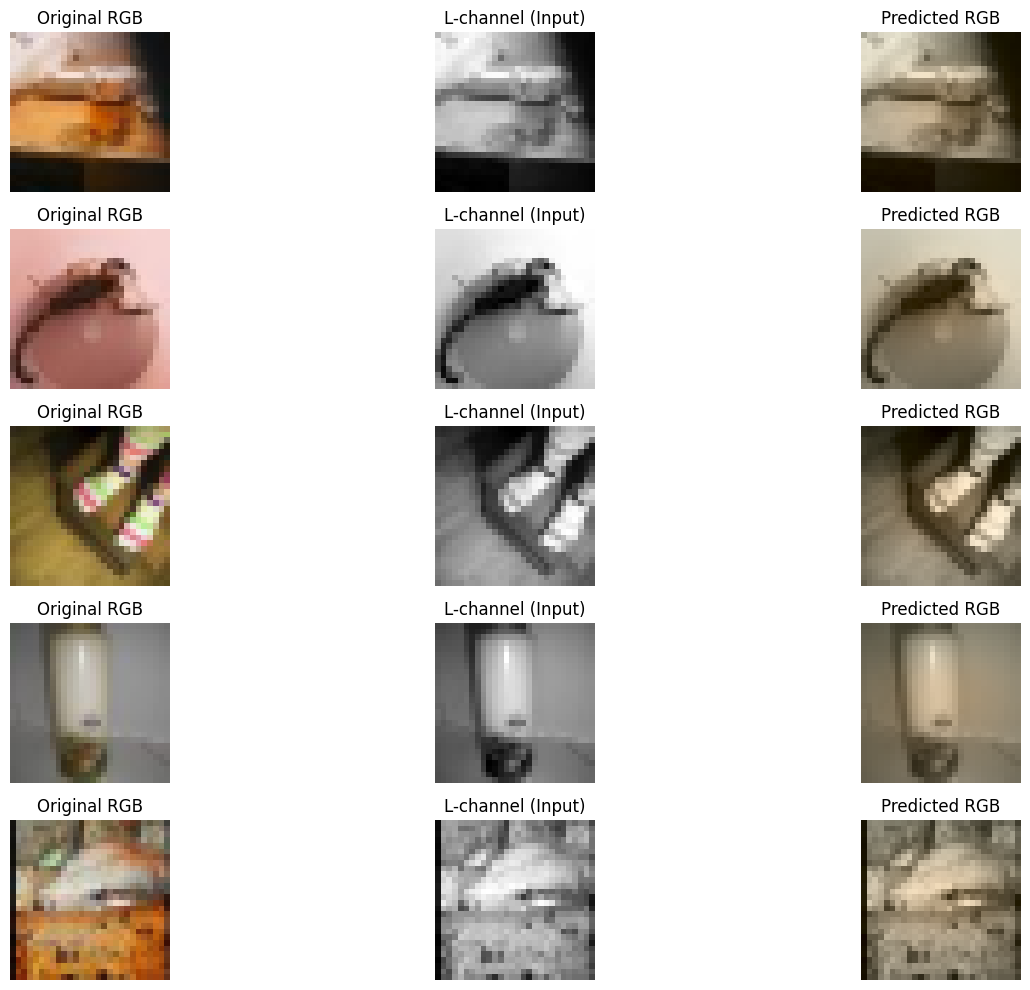

In [ ]:
# Visualize Results and Calculate MSE, R^2
indices = np.random.choice(X_test_pca_np.shape[0], 5, replace=False)
plt.figure(figsize=(15, 10))

for i, idx in enumerate(indices):

    # ----- TRUE L, a, b -----
    true_L = X_test[idx]
    true_a = y_test[idx][:784] #4096 --> 784
    true_b = y_test[idx][784:]

    original_rgb = lab_to_rgb(true_L, true_a, true_b)

    # ----- L-channel -----
    L_img = true_L.reshape(28, 28) / 100.0 #64,64

    # ----- PREDICTION -----
    pred_a = y_pred[idx][:784] #4096
    pred_b = y_pred[idx][784:]

    predicted_rgb = lab_to_rgb(true_L, pred_a, pred_b)

    # ----- PLOT -----
    plt.subplot(5, 3, 3*i + 1)
    plt.imshow(original_rgb)
    plt.title("Original RGB")
    plt.axis("off")

    plt.subplot(5, 3, 3*i + 2)
    plt.imshow(L_img, cmap="gray")
    plt.title("L-channel (Input)")
    plt.axis("off")

    plt.subplot(5, 3, 3*i + 3)
    plt.imshow(predicted_rgb)
    plt.title("Predicted RGB")
    plt.axis("off")

plt.tight_layout()
plt.show()

## 5.0 MSE, SSIM and PSNR
SSIM and PSNR require images with shape of H,W or H,W,3 thefore image must be converted to RGB first



In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

svrssim_scores = []
svrpsnr_scores = []

X_test_np = X_test
for i in range(len(y_pred)):
    # Extract true LAB components
    true_L = X_test_np[i]
    true_a = y_test[i][:784]
    true_b = y_test[i][784:]

    # Extract predictions
    pred_a = y_pred[i][:784]
    pred_b = y_pred[i][784:]

    # Convert to RGB
    orig_rgb = lab_to_rgb(true_L, true_a, true_b)
    pred_rgb = lab_to_rgb(true_L, pred_a, pred_b)

    # Compute metrics
    sss = ssim(orig_rgb, pred_rgb, data_range=1.0, channel_axis=2)
    ppp = psnr(orig_rgb, pred_rgb, data_range=1.0)

    # FIX HERE
    svrssim_scores.append(sss)
    svrpsnr_scores.append(ppp)

# MSE
svr_mse = mean_squared_error(y_test, y_pred)

svr_ssim = np.mean(svrssim_scores)
svr_psnr = np.mean(svrpsnr_scores)

print("MSE:", svr_mse)
print("Mean SSIM:", svr_ssim)
print("Mean PSNR:", svr_psnr)


MSE: 236.68993851183635
Mean SSIM: 0.9134867615606388
Mean PSNR: 22.89711103340709


# Neural Network

## 6.0 Import Libraries


In [ ]:
import glob
from PIL import Image
import numpy as np

from collections import Counter

from torch.utils.data import Dataset, DataLoader
import torch
import os

import torch.nn as nn

from torch.utils.data import Subset
import random

import matplotlib.pyplot as plt

In [ ]:
!pip install pytorch-msssim

In [ ]:
from pytorch_msssim import ssim, ms_ssim
import torch.nn.functional as F

## 7.0 Identify Colorization Dataset


In [ ]:
class ColorizationDataset(Dataset):
    def __init__(self, root):
        # Recursively collect all JPEG files under the root directory
        self.files = glob.glob(root + "/**/*.[Jj][Pp][Ee][Gg]", recursive=True)

    def rgb_to_gray(self, img):
        # Convert PIL image to NumPy array (H, W, 3)
        arr = np.array(img)

        # Convert RGB to grayscale using the standard BT.601 luminance formula
        gray = 0.2989 * arr[...,0] + 0.5870 * arr[...,1] + 0.1140 * arr[...,2]

        # Normalize grayscale values to range [0, 1]
        return gray / 255.0

    def __len__(self):
        # Return total number of images in the dataset
        return len(self.files)

    def __getitem__(self, idx):
        # Get the file path for the idx-th image
        path = self.files[idx]

        # Load image and ensure it is in RGB format
        img = Image.open(path).convert("RGB")

        # Convert RGB image to NumPy array and normalize to [0, 1]
        rgb = np.array(img) / 255.0

        # Compute grayscale version of the image
        gray = self.rgb_to_gray(img)

        # Convert grayscale to tensor with shape (1, H, W)
        gray = torch.tensor(gray).unsqueeze(0).float()      # (1,H,W)

        # Convert RGB to tensor and reorder to (3, H, W) for PyTorch
        rgb  = torch.tensor(rgb).permute(2,0,1).float()     # (3,H,W)

        return gray, rgb


# Create dataset objects for training, validation, and testing
train_dataset = ColorizationDataset(train_dir)
val_dataset   = ColorizationDataset(val_dir)
test_dataset  = ColorizationDataset(test_dir)

# Create DataLoaders to feed data into the model in mini-batches

# DataLoader for training:
# - batch_size=8: process 8 images at a time
# - shuffle=True: shuffle training images every epoch for better learning
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# DataLoader for validation:
# - No shuffling: evaluation must be deterministic
val_loader   = DataLoader(val_dataset, batch_size=8)

# DataLoader for testing:
# - batch_size=1: evaluate one image at a time for accurate visualization/results
test_loader  = DataLoader(test_dataset, batch_size=1)


print("Train:", len(train_dataset))
print("Val:", len(val_dataset))
print("Test:", len(test_dataset))

Train: 100000
Val: 10000
Test: 10000


In [ ]:
# Create dataset objects for training, validation, and testing
train_dataset = ColorizationDataset(train_dir)
val_dataset   = ColorizationDataset(val_dir)
test_dataset  = ColorizationDataset(test_dir)

# Create DataLoaders to feed data into the model in mini-batches

# DataLoader for training:
# - batch_size=8: process 8 images at a time
# - shuffle=True: shuffle training images every epoch for better learning
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# DataLoader for validation:
# - No shuffling: evaluation must be deterministic
val_loader   = DataLoader(val_dataset, batch_size=8)

# DataLoader for testing:
# - batch_size=1: evaluate one image at a time for accurate visualization/results
test_loader  = DataLoader(test_dataset, batch_size=1)

In [ ]:
print("Train:", len(train_dataset))
print("Val:", len(val_dataset))
print("Test:", len(test_dataset))

Train: 100000
Val: 10000
Test: 10000


## 8.0 Apply Baseline Model
We implement a naive baseline model to establish a reference performance level.
The baseline model either replicates the grayscale channel into three RGB channels
or uses a shallow convolutional autoencoder without skip connections.

## 8.1 Build Baseline


In [ ]:
import torch.nn as nn

class BaselineColorizer(nn.Module):
    def __init__(self):
        super(BaselineColorizer, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 1→32
            nn.ReLU(),
            nn.MaxPool2d(2),         # 1/2 size

            nn.Conv2d(32, 64, 3, padding=1),             # 32→64
            nn.ReLU(),
            nn.MaxPool2d(2),         # 1/4 size

            nn.Conv2d(64, 128, 3, padding=1),            # 64→128
            nn.ReLU(),
            nn.MaxPool2d(2)          # 1/8 size
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2),    # 1/8→1/4
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, 2, stride=2),     # 1/4→1/2
            nn.ReLU(),

            nn.ConvTranspose2d(32, 3, 2, stride=2),      # 1/2→原图大小, 输出3通道RGB
            nn.Sigmoid()  # [0,1]
        )

    def forward(self, x):
        latent = self.encoder(x)
        out = self.decoder(latent)
        return out

In [ ]:
def compute_metrics(pred, target):
    """
    pred:   (B,3,H,W) predicted RGB image
    target: (B,3,H,W) ground truth
    Returns average SSIM and PSNR across batch.
    """

    # SSIM
    ssim_score = ssim(pred, target, data_range=1.0, size_average=True)

    # PSNR
    mse = F.mse_loss(pred, target)
    psnr_score = -10 * torch.log10(mse)

    return ssim_score.item(), psnr_score.item()

### 8.1.1 MSE Loss to train

In [ ]:
%%time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Dataset Sampling ----
train_dataset_full = ColorizationDataset(train_dir)
indices = random.sample(range(len(train_dataset_full)), 100000) # 100000
train_dataset = Subset(train_dataset_full, indices)

val_dataset_full = ColorizationDataset(val_dir)
indices = random.sample(range(len(val_dataset_full)), 10000) # 10000
val_dataset = Subset(val_dataset_full, indices)

test_dataset_full = ColorizationDataset(test_dir)
indices = random.sample(range(len(test_dataset_full)), 10000) # 10000
test_dataset = Subset(test_dataset_full, indices)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# ---- Define Baseline model + loss + optimizer ----
baseline = BaselineColorizer().to(device)
criterion = nn.MSELoss()
l1_metric = nn.L1Loss()

optimizer = torch.optim.Adam(baseline.parameters(), lr=1e-4)

epochs = 40

train_loss_list = []
val_loss_list = []
val_l1_list = []
ssim_list = []
psnr_list = []

# ---- Step 3 checkpoint tracking ----
best_ssim = -1   # SSIM: higher is better
best_epoch = 0

for epoch in range(epochs):

    # ---- Training ----
    baseline.train()
    train_loss = 0

    for gray, rgb in train_loader:
        gray, rgb = gray.to(device), rgb.to(device)

        pred = baseline(gray)
        loss = criterion(pred, rgb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # ---- Validation ----
    baseline.eval()
    val_loss = 0
    val_l1   = 0
    val_ssim = 0
    val_psnr = 0

    with torch.no_grad():
        for gray, rgb in val_loader:
            gray, rgb = gray.to(device), rgb.to(device)

            pred = baseline(gray)

            loss = criterion(pred, rgb)
            val_loss += loss.item()

            l1 = l1_metric(pred, rgb)
            val_l1 += l1.item()

            s, p = compute_metrics(pred, rgb)
            val_ssim += s
            val_psnr += p

    # ---- Averages ----
    train_loss /= len(train_loader)
    val_loss   /= len(val_loader)
    val_l1     /= len(val_loader)
    val_ssim   /= len(val_loader)
    val_psnr   /= len(val_loader)

    # ---- Print ----
    print(
        f"[Baseline] Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | "
        f"Val MSE: {val_loss:.4f} | Val L1: {val_l1:.4f} | "
        f"SSIM: {val_ssim:.4f} | PSNR: {val_psnr:.2f} dB"
    )

    # ---- (NEW) Step 3: Best Checkpoint Saving ----
    if val_ssim > best_ssim:  # SSIM: higher means better
        best_ssim = val_ssim
        best_epoch = epoch + 1

        torch.save(baseline.state_dict(), "best_model_ssim.pth")
        print(f"🔥 New best model saved at epoch {epoch+1} with SSIM={val_ssim:.4f}")

    # ---- Store metrics for plotting ----
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    val_l1_list.append(val_l1)
    ssim_list.append(val_ssim)
    psnr_list.append(val_psnr)

print(f"✔ Training complete — best model was epoch {best_epoch} with SSIM={best_ssim:.4f}")

[Baseline] Epoch 1/40 | Train Loss: 0.0235 | Val MSE: 0.0205 | Val L1: 0.1024 | SSIM: 0.4529 | PSNR: 17.00 dB
🔥 New best model saved at epoch 1 with SSIM=0.4529
[Baseline] Epoch 2/40 | Train Loss: 0.0196 | Val MSE: 0.0189 | Val L1: 0.0981 | SSIM: 0.5047 | PSNR: 17.37 dB
🔥 New best model saved at epoch 2 with SSIM=0.5047
[Baseline] Epoch 3/40 | Train Loss: 0.0185 | Val MSE: 0.0182 | Val L1: 0.0956 | SSIM: 0.5319 | PSNR: 17.52 dB
🔥 New best model saved at epoch 3 with SSIM=0.5319
[Baseline] Epoch 4/40 | Train Loss: 0.0178 | Val MSE: 0.0175 | Val L1: 0.0939 | SSIM: 0.5511 | PSNR: 17.69 dB
🔥 New best model saved at epoch 4 with SSIM=0.5511
[Baseline] Epoch 5/40 | Train Loss: 0.0173 | Val MSE: 0.0172 | Val L1: 0.0929 | SSIM: 0.5645 | PSNR: 17.78 dB
🔥 New best model saved at epoch 5 with SSIM=0.5645
[Baseline] Epoch 6/40 | Train Loss: 0.0169 | Val MSE: 0.0167 | Val L1: 0.0913 | SSIM: 0.5749 | PSNR: 17.92 dB
🔥 New best model saved at epoch 6 with SSIM=0.5749
[Baseline] Epoch 7/40 | Train Loss

In [ ]:
best_model = BaselineColorizer().to(device)
best_model.load_state_dict(torch.load("best_model_ssim.pth"))
best_model.eval()
print("Best model loaded for testing / visualization!")

Best model loaded for testing / visualization!


In [ ]:
# ====== Load Best Model Checkpoint ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_model = BaselineColorizer().to(device)
best_model.load_state_dict(torch.load("best_model_ssim.pth"))
best_model.eval()

print("✔ Best model loaded!")


# ====== Define Test Metrics ======
mse_metric = nn.MSELoss()
l1_metric  = nn.L1Loss()

test_mse  = 0
test_l1   = 0
test_ssim = 0
test_psnr = 0

# ====== Test Evaluation Loop ======
with torch.no_grad():
    for gray, rgb in test_loader:  # Make sure you have test_loader defined
        gray = gray.to(device)
        rgb  = rgb.to(device)

        pred = best_model(gray)

        # Pixel metrics
        mse = mse_metric(pred, rgb)
        l1  = l1_metric(pred, rgb)

        test_mse  += mse.item()
        test_l1   += l1.item()

        # Perceptual metrics
        s, p = compute_metrics(pred, rgb)  # your SSIM + PSNR function
        test_ssim += s
        test_psnr += p


# ====== Average Metrics ======
test_mse  /= len(test_loader)
test_l1   /= len(test_loader)
test_ssim /= len(test_loader)
test_psnr /= len(test_loader)


print("\n🔹 FINAL TEST RESULTS (Best SSIM Model) 🔹")
print("-----------------------------------------")
print(f"Test MSE  = {test_mse:.6f}")
print(f"Test L1   = {test_l1:.6f}")
print(f"Test SSIM = {test_ssim:.4f}")
print(f"Test PSNR = {test_psnr:.2f} dB")
print("-----------------------------------------\n")

✔ Best model loaded!

🔹 FINAL TEST RESULTS (Best SSIM Model) 🔹
-----------------------------------------
Test MSE  = 0.014489
Test L1   = 0.084472
Test SSIM = 0.6624
Test PSNR = 18.56 dB
-----------------------------------------



In [ ]:
# Test metrics: MSE, L1, SSIM, PSNR
##########################
baseline_mse_mse  = test_mse
baseline_mse_l1  = test_l1
baseline_mse_ssim = test_ssim
baseline_mse_psnr = test_psnr
##########################

#### Visualization

##### Train vs Validation Loss Curve (MSE and L1)

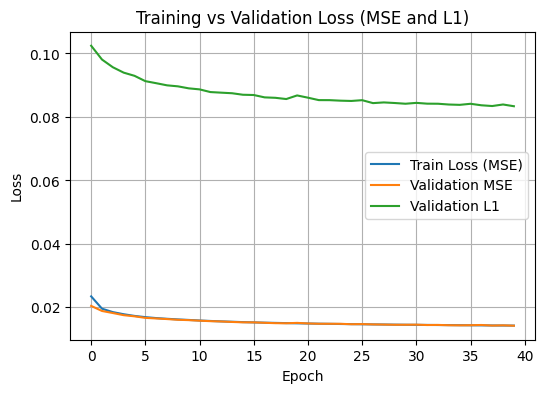

In [ ]:
plt.figure(figsize=(6,4))

plt.plot(train_loss_list, label="Train Loss (MSE)")
plt.plot(val_loss_list, label="Validation MSE")
plt.plot(val_l1_list, label="Validation L1")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (MSE and L1)")
plt.legend()
plt.grid(True)
plt.show()

##### SSIM Curve

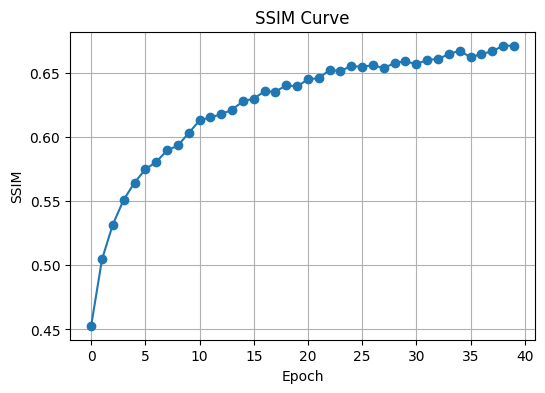

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(ssim_list, marker='o')
plt.xlabel("Epoch")
plt.ylabel("SSIM")
plt.title("SSIM Curve")
plt.grid(True)
plt.show()

##### PSNR Curve

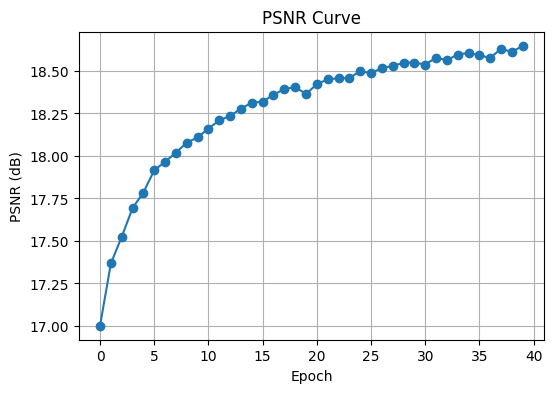

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(psnr_list, marker='o')
plt.xlabel("Epoch")
plt.ylabel("PSNR (dB)")
plt.title("PSNR Curve")
plt.grid(True)
plt.show()

##### Images

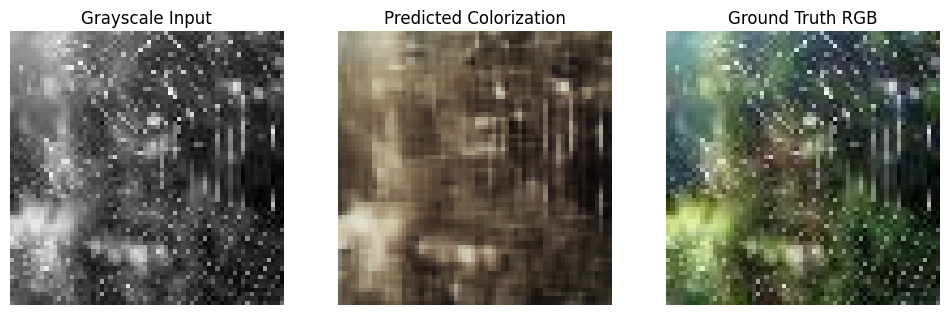

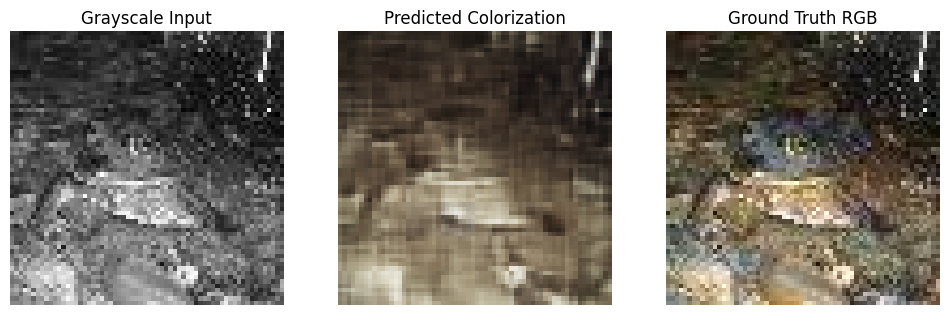

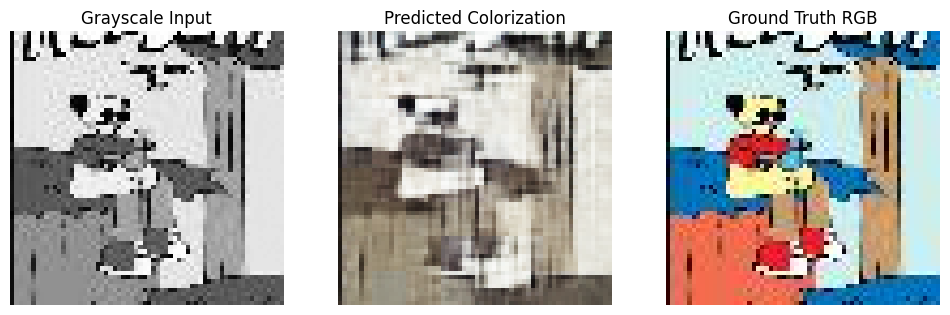

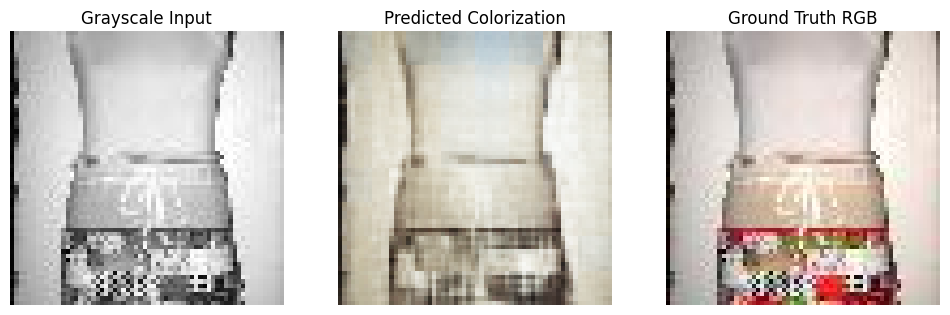

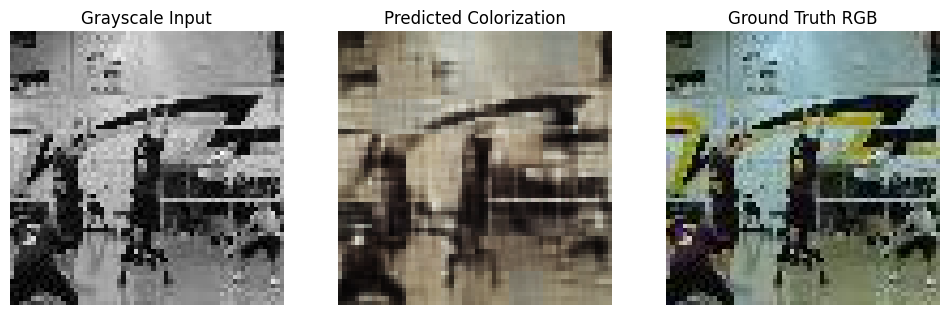

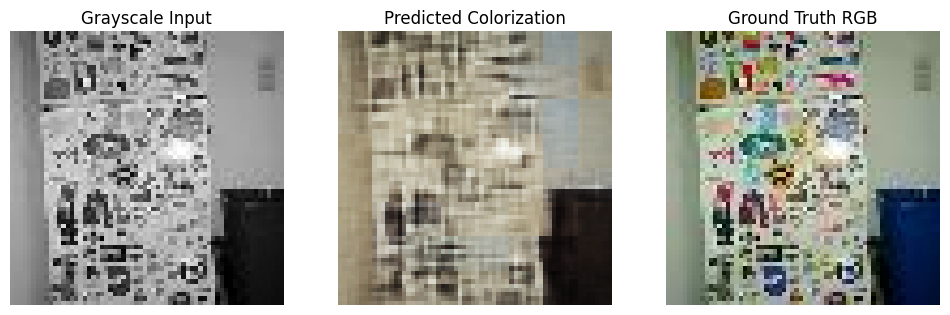

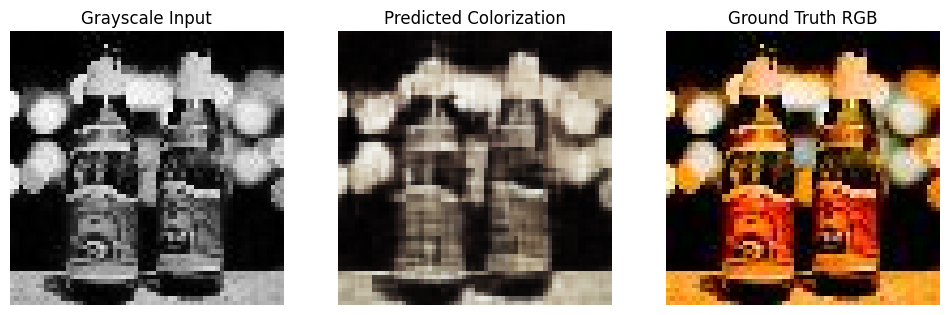

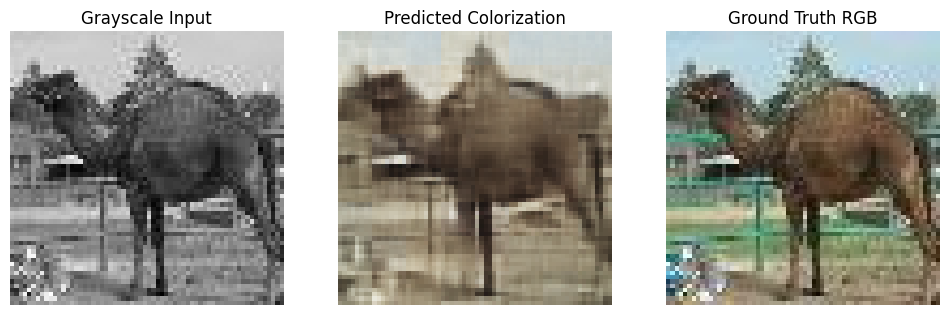

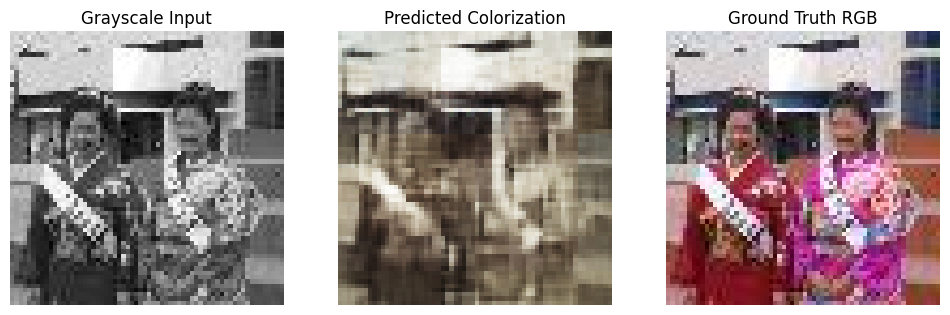

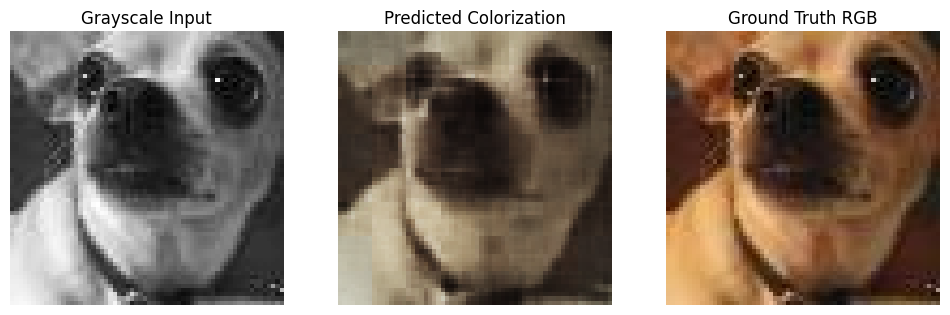

In [ ]:
def visualize_colorization(gray, pred, rgb):
    gray = gray[0].cpu().squeeze().numpy()
    pred = pred[0].cpu().permute(1,2,0).numpy()
    rgb  = rgb[0].cpu().permute(1,2,0).numpy()

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.title("Grayscale Input"); plt.imshow(gray, cmap="gray"); plt.axis("off")
    plt.subplot(1,3,2); plt.title("Predicted Colorization"); plt.imshow(pred); plt.axis("off")
    plt.subplot(1,3,3); plt.title("Ground Truth RGB"); plt.imshow(rgb); plt.axis("off")
    plt.show()

# Example visualization
baseline.eval()

# randomly pick 10 indices
indices = random.sample(range(len(val_dataset)), 10)

for idx in indices:
    gray, rgb = val_dataset[idx]   # get one sample from validation dataset

    # Add batch dimension (1, C, H, W)
    gray = gray.unsqueeze(0).to(device)
    rgb  = rgb.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = baseline(gray)

    visualize_colorization(gray, pred, rgb)

### 8.1.2 L1 Loss to train

In [ ]:
%%time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Dataset Sampling ----
train_dataset_full = ColorizationDataset(train_dir)
indices = random.sample(range(len(train_dataset_full)), 100000) # 100000
train_dataset = Subset(train_dataset_full, indices)

val_dataset_full = ColorizationDataset(val_dir)
indices = random.sample(range(len(val_dataset_full)), 10000) # 10000
val_dataset = Subset(val_dataset_full, indices)

test_dataset_full = ColorizationDataset(test_dir)
indices = random.sample(range(len(test_dataset_full)), 10000) # 10000
test_dataset = Subset(test_dataset_full, indices)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# ---- Define Baseline model + loss + optimizer ----
baseline = BaselineColorizer().to(device)

# Train loss = L1
criterion = nn.L1Loss()

# Validation metrics
l1_metric  = nn.L1Loss()
mse_metric = nn.MSELoss()

optimizer = torch.optim.Adam(baseline.parameters(), lr=1e-4)

epochs = 40

train_loss_list = []
val_mse_list = []
val_l1_list = []
ssim_list = []
psnr_list = []

# ---- Step 3: checkpoint tracking ----
best_ssim = -1
best_epoch = 0

for epoch in range(epochs):

    # ---- Training ----
    baseline.train()
    train_loss = 0

    for gray, rgb in train_loader:
        gray, rgb = gray.to(device), rgb.to(device)

        pred = baseline(gray)

        # training loss = L1
        loss = criterion(pred, rgb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # ---- Validation ----
    baseline.eval()
    val_mse = 0
    val_l1  = 0
    val_ssim = 0
    val_psnr = 0

    with torch.no_grad():
        for gray, rgb in val_loader:
            gray, rgb = gray.to(device), rgb.to(device)

            pred = baseline(gray)

            # Validation MSE
            mse = mse_metric(pred, rgb)
            val_mse += mse.item()

            # Validation L1
            l1 = l1_metric(pred, rgb)
            val_l1 += l1.item()

            # SSIM & PSNR
            s, p = compute_metrics(pred, rgb)
            val_ssim += s
            val_psnr += p

    # ---- Average ----
    train_loss /= len(train_loader)
    val_mse    /= len(val_loader)
    val_l1     /= len(val_loader)
    val_ssim   /= len(val_loader)
    val_psnr   /= len(val_loader)

    # ---- Print ----
    print(
        f"[Baseline L1 Train] Epoch {epoch+1}/{epochs} | "
        f"Train L1: {train_loss:.4f} | "
        f"Val MSE: {val_mse:.4f} | "
        f"Val L1: {val_l1:.4f} | "
        f"SSIM: {val_ssim:.4f} | PSNR: {val_psnr:.2f} dB"
    )

    # ---- Step 3: save best checkpoint based on SSIM ----
    if val_ssim > best_ssim:
        best_ssim = val_ssim
        best_epoch = epoch + 1
        torch.save(baseline.state_dict(), "best_model_ssim_L1train.pth")
        print(f"🔥 New best model saved at epoch {epoch+1} with SSIM={val_ssim:.4f}")

    # ---- Track metrics ----
    train_loss_list.append(train_loss)
    val_mse_list.append(val_mse)
    val_l1_list.append(val_l1)
    ssim_list.append(val_ssim)
    psnr_list.append(val_psnr)

print(f"✔ Training finished — best model was epoch {best_epoch} with SSIM={best_ssim:.4f}")

[Baseline L1 Train] Epoch 1/40 | Train L1: 0.1117 | Val MSE: 0.0216 | Val L1: 0.1031 | SSIM: 0.4382 | PSNR: 16.76 dB
🔥 New best model saved at epoch 1 with SSIM=0.4382
[Baseline L1 Train] Epoch 2/40 | Train L1: 0.1006 | Val MSE: 0.0199 | Val L1: 0.0982 | SSIM: 0.4854 | PSNR: 17.13 dB
🔥 New best model saved at epoch 2 with SSIM=0.4854
[Baseline L1 Train] Epoch 3/40 | Train L1: 0.0970 | Val MSE: 0.0192 | Val L1: 0.0962 | SSIM: 0.5129 | PSNR: 17.30 dB
🔥 New best model saved at epoch 3 with SSIM=0.5129
[Baseline L1 Train] Epoch 4/40 | Train L1: 0.0951 | Val MSE: 0.0187 | Val L1: 0.0942 | SSIM: 0.5362 | PSNR: 17.43 dB
🔥 New best model saved at epoch 4 with SSIM=0.5362
[Baseline L1 Train] Epoch 5/40 | Train L1: 0.0939 | Val MSE: 0.0183 | Val L1: 0.0935 | SSIM: 0.5466 | PSNR: 17.51 dB
🔥 New best model saved at epoch 5 with SSIM=0.5466
[Baseline L1 Train] Epoch 6/40 | Train L1: 0.0929 | Val MSE: 0.0178 | Val L1: 0.0922 | SSIM: 0.5577 | PSNR: 17.63 dB
🔥 New best model saved at epoch 6 with SSIM

In [ ]:
# ====== Load Best Saved Model ======
best_model = BaselineColorizer().to(device)
best_model.load_state_dict(torch.load("best_model_ssim_L1train.pth"))
best_model.eval()

print("✔ Best SSIM model loaded for testing!")


# ====== Define Test Metrics ======
test_mse  = 0
test_l1   = 0
test_ssim = 0
test_psnr = 0

with torch.no_grad():
    for gray, rgb in test_loader:
        gray = gray.to(device)
        rgb  = rgb.to(device)

        pred = best_model(gray)

        # Numeric errors
        test_mse  += mse_metric(pred, rgb).item()
        test_l1   += l1_metric(pred, rgb).item()

        # Perceptual quality
        s, p = compute_metrics(pred, rgb)
        test_ssim += s
        test_psnr += p

# ====== Average ======
test_mse  /= len(test_loader)
test_l1   /= len(test_loader)
test_ssim /= len(test_loader)
test_psnr /= len(test_loader)

print("\n🔹 FINAL TEST RESULTS (Best SSIM Model — L1-trained) 🔹")
print("-------------------------------------------------------")
print(f"Test MSE  = {test_mse:.6f}")
print(f"Test L1   = {test_l1:.6f}")
print(f"Test SSIM = {test_ssim:.4f}")
print(f"Test PSNR = {test_psnr:.2f} dB")
print("-------------------------------------------------------\n")

✔ Best SSIM model loaded for testing!

🔹 FINAL TEST RESULTS (Best SSIM Model — L1-trained) 🔹
-------------------------------------------------------
Test MSE  = 0.014991
Test L1   = 0.084288
Test SSIM = 0.6619
Test PSNR = 18.40 dB
-------------------------------------------------------



In [ ]:
# Test metrics: MSE, L1, SSIM, PSNR
##########################
baseline_l1_mse  = test_mse
baseline_l1_l1  = test_l1
baseline_l1_ssim = test_ssim
baseline_l1_psnr = test_psnr
##########################

#### Visualization

##### Train vs Validation Loss Curve (MSE and L1)

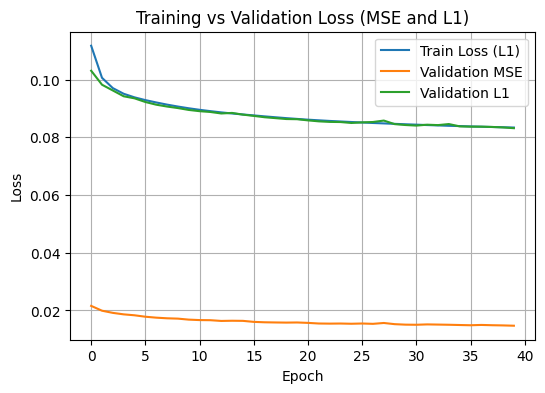

In [ ]:
plt.figure(figsize=(6,4))

plt.plot(train_loss_list, label="Train Loss (L1)")
plt.plot(val_mse_list, label="Validation MSE")
plt.plot(val_l1_list, label="Validation L1")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (MSE and L1)")
plt.legend()
plt.grid(True)
plt.show()

##### SSIM Curve

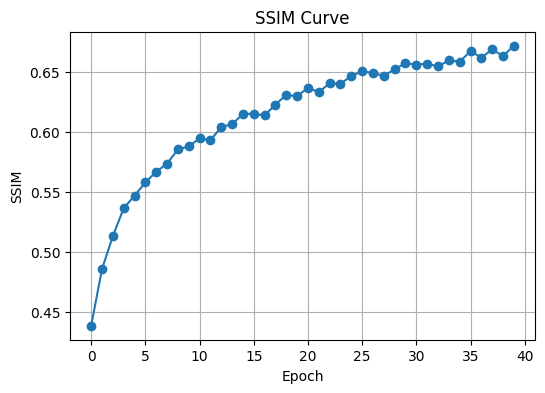

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(ssim_list, marker='o')
plt.xlabel("Epoch")
plt.ylabel("SSIM")
plt.title("SSIM Curve")
plt.grid(True)
plt.show()

##### PSNR Curve

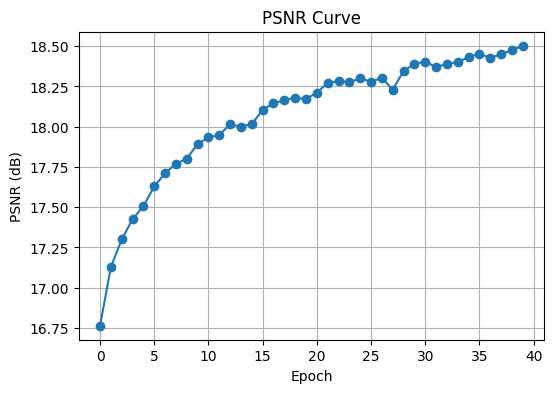

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(psnr_list, marker='o')
plt.xlabel("Epoch")
plt.ylabel("PSNR (dB)")
plt.title("PSNR Curve")
plt.grid(True)
plt.show()

##### Images

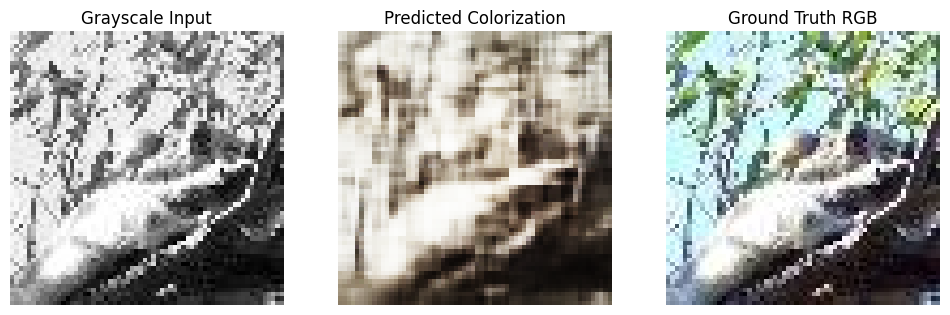

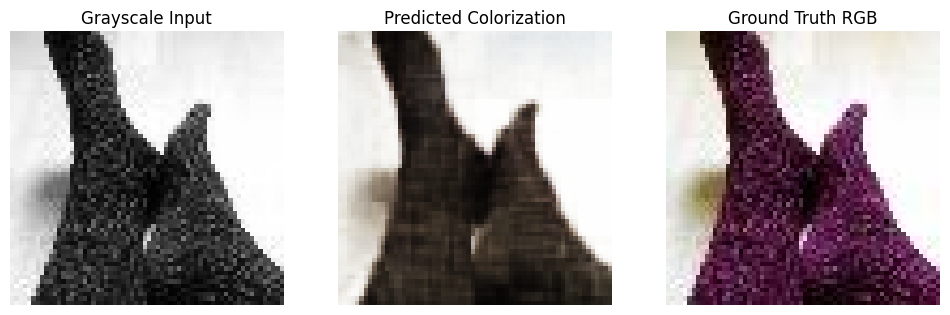

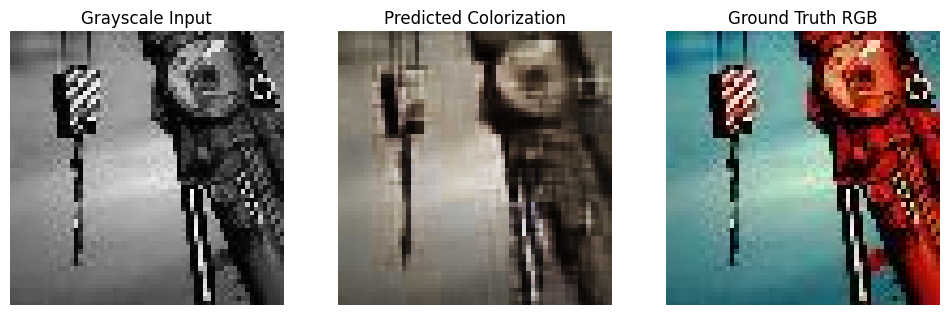

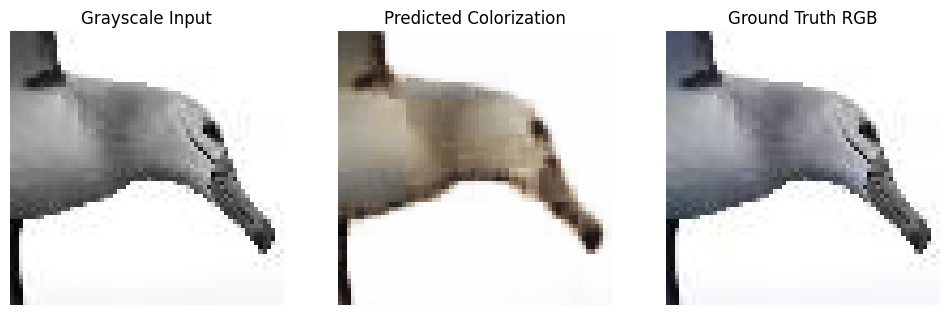

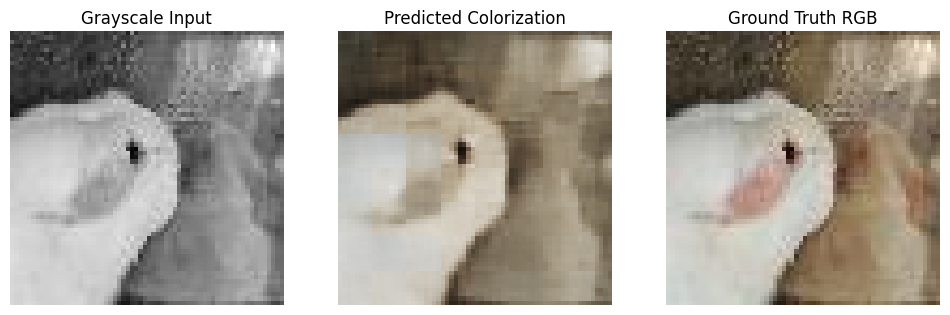

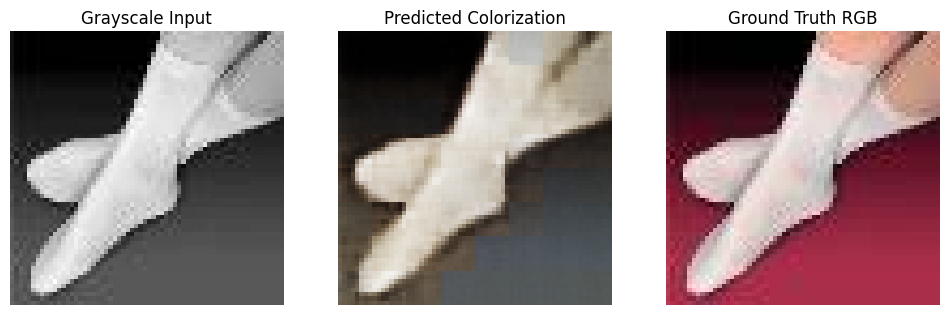

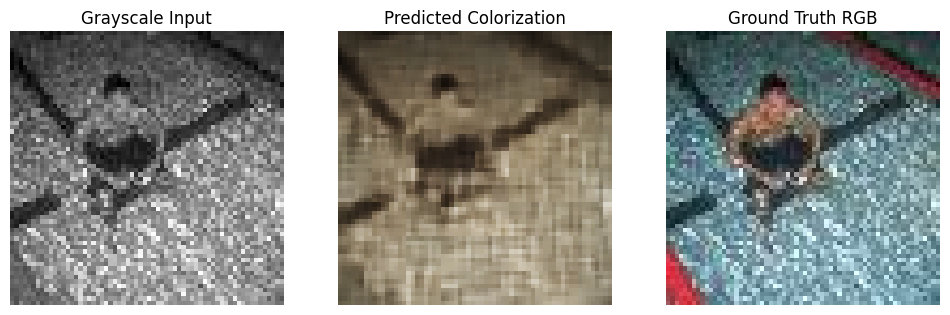

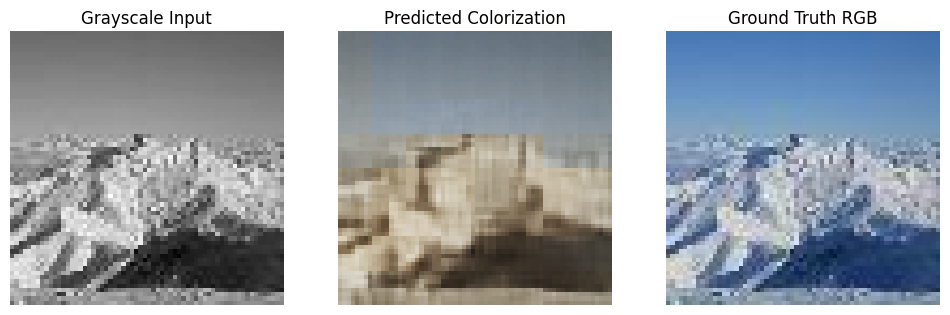

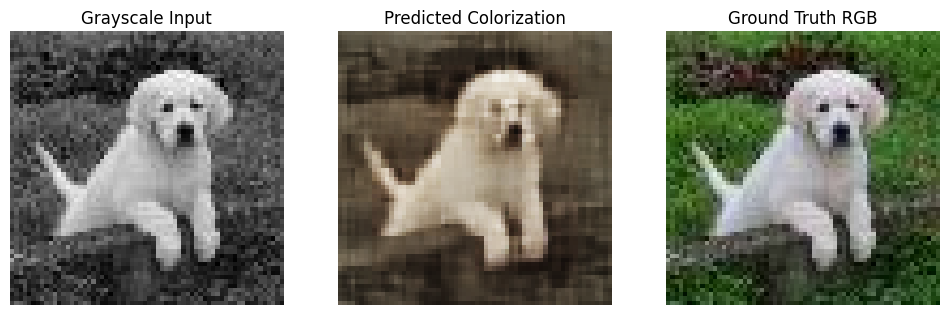

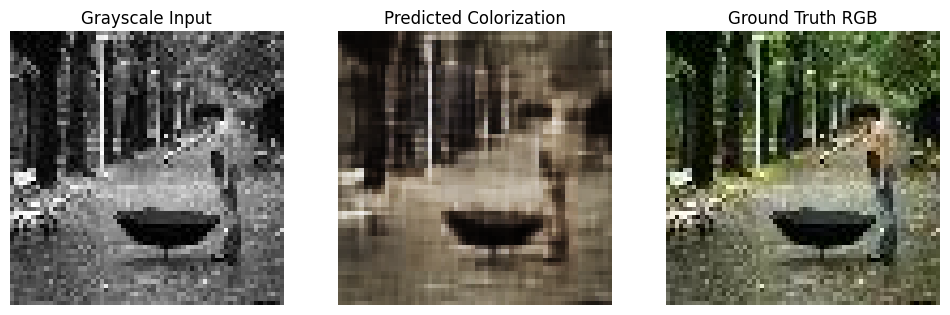

In [ ]:
def visualize_colorization(gray, pred, rgb):
    gray = gray[0].cpu().squeeze().numpy()
    pred = pred[0].cpu().permute(1,2,0).numpy()
    rgb  = rgb[0].cpu().permute(1,2,0).numpy()

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.title("Grayscale Input"); plt.imshow(gray, cmap="gray"); plt.axis("off")
    plt.subplot(1,3,2); plt.title("Predicted Colorization"); plt.imshow(pred); plt.axis("off")
    plt.subplot(1,3,3); plt.title("Ground Truth RGB"); plt.imshow(rgb); plt.axis("off")
    plt.show()

# Example visualization
baseline.eval()

# randomly pick 10 indices
indices = random.sample(range(len(val_dataset)), 10)

for idx in indices:
    gray, rgb = val_dataset[idx]   # get one sample from validation dataset

    # Add batch dimension (1, C, H, W)
    gray = gray.unsqueeze(0).to(device)
    rgb  = rgb.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = baseline(gray)

    visualize_colorization(gray, pred, rgb)

### 8.1.3 Hybrid Loss to train

In [ ]:
%%time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Dataset Sampling ----
train_dataset_full = ColorizationDataset(train_dir)
indices = random.sample(range(len(train_dataset_full)), 100000) # 100000
train_dataset = Subset(train_dataset_full, indices)

val_dataset_full = ColorizationDataset(val_dir)
indices = random.sample(range(len(val_dataset_full)), 10000) # 10000
val_dataset = Subset(val_dataset_full, indices)

test_dataset_full = ColorizationDataset(test_dir)
indices = random.sample(range(len(test_dataset_full)), 10000) # 10000
test_dataset = Subset(test_dataset_full, indices)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False)

# ---- Define Baseline model ----
baseline = BaselineColorizer().to(device)

# Hybrid loss components
criterion_l1  = nn.L1Loss()
criterion_mse = nn.MSELoss()

alpha, beta = 0.8, 0.2  # weights for hybrid loss

optimizer = torch.optim.Adam(baseline.parameters(), lr=1e-4)

epochs = 40

train_loss_list = []
val_hybrid_list = []
val_mse_list = []
val_l1_list = []
ssim_list = []
psnr_list = []

# ---- Step 3 checkpoint tracking ----
best_ssim = -1
best_epoch = 0

for epoch in range(epochs):

    # ---- Training ----
    baseline.train()
    train_loss = 0

    for gray, rgb in train_loader:
        gray, rgb = gray.to(device), rgb.to(device)

        pred = baseline(gray)

        # Hybrid training loss
        loss_l1  = criterion_l1(pred, rgb)
        loss_mse = criterion_mse(pred, rgb)
        loss     = alpha * loss_l1 + beta * loss_mse

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # ---- Validation ----
    baseline.eval()
    val_hybrid = 0
    val_mse = 0
    val_l1  = 0
    val_ssim = 0
    val_psnr = 0

    with torch.no_grad():
        for gray, rgb in val_loader:
            gray, rgb = gray.to(device), rgb.to(device)

            pred = baseline(gray)

            # Hybrid loss for validation
            loss_l1_val  = criterion_l1(pred, rgb)
            loss_mse_val = criterion_mse(pred, rgb)
            hybrid_val_loss = alpha * loss_l1_val + beta * loss_mse_val

            val_hybrid += hybrid_val_loss.item()

            # Separate evaluation metrics
            val_mse += loss_mse_val.item()
            val_l1  += loss_l1_val.item()

            # SSIM & PSNR
            s, p = compute_metrics(pred, rgb)
            val_ssim += s
            val_psnr += p

    # ---- Averages ----
    train_loss /= len(train_loader)
    val_hybrid /= len(val_loader)
    val_mse    /= len(val_loader)
    val_l1     /= len(val_loader)
    val_ssim   /= len(val_loader)
    val_psnr   /= len(val_loader)

    # ---- Print ----
    print(
        f"[Hybrid Train] Epoch {epoch+1}/{epochs} | "
        f"Train Hybrid: {train_loss:.4f} | "
        f"Val Hybrid: {val_hybrid:.4f} | "
        f"Val MSE: {val_mse:.4f} | "
        f"Val L1: {val_l1:.4f} | "
        f"SSIM: {val_ssim:.4f} | PSNR: {val_psnr:.2f} dB"
    )

    # ---- Step 3: Save best checkpoint by validation SSIM ----
    if val_ssim > best_ssim:
        best_ssim = val_ssim
        best_epoch = epoch + 1

        torch.save(baseline.state_dict(), "best_model_hybrid_ssim.pth")
        print(f"🔥 New best Hybrid model saved at epoch {epoch+1} with SSIM={val_ssim:.4f}")

    # ---- Record metrics ----
    train_loss_list.append(train_loss)
    val_hybrid_list.append(val_hybrid)
    val_mse_list.append(val_mse)
    val_l1_list.append(val_l1)
    ssim_list.append(val_ssim)
    psnr_list.append(val_psnr)

print(f"\n✔ Training finished — best model was epoch {best_epoch} with SSIM={best_ssim:.4f}")

[Hybrid Train] Epoch 1/40 | Train Hybrid: 0.0928 | Val Hybrid: 0.0866 | Val MSE: 0.0214 | Val L1: 0.1029 | SSIM: 0.4480 | PSNR: 16.80 dB
🔥 New best Hybrid model saved at epoch 1 with SSIM=0.4480
[Hybrid Train] Epoch 2/40 | Train Hybrid: 0.0832 | Val Hybrid: 0.0811 | Val MSE: 0.0193 | Val L1: 0.0966 | SSIM: 0.5049 | PSNR: 17.26 dB
🔥 New best Hybrid model saved at epoch 2 with SSIM=0.5049
[Hybrid Train] Epoch 3/40 | Train Hybrid: 0.0802 | Val Hybrid: 0.0792 | Val MSE: 0.0185 | Val L1: 0.0944 | SSIM: 0.5352 | PSNR: 17.46 dB
🔥 New best Hybrid model saved at epoch 3 with SSIM=0.5352
[Hybrid Train] Epoch 4/40 | Train Hybrid: 0.0786 | Val Hybrid: 0.0778 | Val MSE: 0.0180 | Val L1: 0.0927 | SSIM: 0.5503 | PSNR: 17.60 dB
🔥 New best Hybrid model saved at epoch 4 with SSIM=0.5503
[Hybrid Train] Epoch 5/40 | Train Hybrid: 0.0775 | Val Hybrid: 0.0767 | Val MSE: 0.0175 | Val L1: 0.0915 | SSIM: 0.5668 | PSNR: 17.72 dB
🔥 New best Hybrid model saved at epoch 5 with SSIM=0.5668
[Hybrid Train] Epoch 6/40

In [ ]:
# ====== Load Best Model Checkpoint ======
best_model = BaselineColorizer().to(device)
best_model.load_state_dict(torch.load("best_model_hybrid_ssim.pth"))
best_model.eval()

print("✔ Best SSIM Hybrid Model loaded for testing!")

# ====== Define Metrics ======
test_mse  = 0
test_l1   = 0
test_ssim = 0
test_psnr = 0

with torch.no_grad():
    for gray, rgb in test_loader:
        gray = gray.to(device)
        rgb  = rgb.to(device)

        pred = best_model(gray)

        # Numeric metrics
        test_mse  += criterion_mse(pred, rgb).item()
        test_l1   += criterion_l1(pred, rgb).item()

        # Perceptual metrics
        s, p = compute_metrics(pred, rgb)
        test_ssim += s
        test_psnr += p

# ====== Average ======
test_mse  /= len(test_loader)
test_l1   /= len(test_loader)
test_ssim /= len(test_loader)
test_psnr /= len(test_loader)

print("\n🔹 FINAL TEST RESULTS (Best Hybrid SSIM Model) 🔹")
print("-------------------------------------------------")
print(f"Test MSE  = {test_mse:.6f}")
print(f"Test L1   = {test_l1:.6f}")
print(f"Test SSIM = {test_ssim:.4f}")
print(f"Test PSNR = {test_psnr:.2f} dB")
print("-------------------------------------------------\n")

✔ Best SSIM Hybrid Model loaded for testing!

🔹 FINAL TEST RESULTS (Best Hybrid SSIM Model) 🔹
-------------------------------------------------
Test MSE  = 0.014803
Test L1   = 0.083720
Test SSIM = 0.6723
Test PSNR = 18.47 dB
-------------------------------------------------



In [ ]:
# Test metrics: MSE, L1, SSIM, PSNR
##########################
baseline_hybrid_mse  = test_mse
baseline_hybrid_l1  = test_l1
baseline_hybrid_ssim = test_ssim
baseline_hybrid_psnr = test_psnr
##########################

#### Visualization

##### Train vs Validation Loss Curve (MSE and L1)

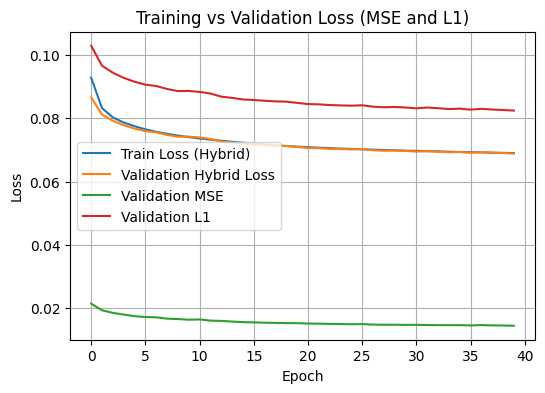

In [ ]:
plt.figure(figsize=(6,4))

plt.plot(train_loss_list, label="Train Loss (Hybrid)")
plt.plot(val_hybrid_list, label="Validation Hybrid Loss")
plt.plot(val_mse_list, label="Validation MSE")
plt.plot(val_l1_list, label="Validation L1")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (MSE and L1)")
plt.legend()
plt.grid(True)
plt.show()

##### SSIM Curve

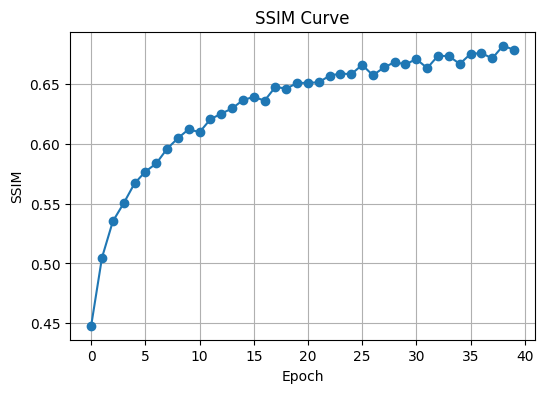

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(ssim_list, marker='o')
plt.xlabel("Epoch")
plt.ylabel("SSIM")
plt.title("SSIM Curve")
plt.grid(True)
plt.show()

##### PSNR Curve

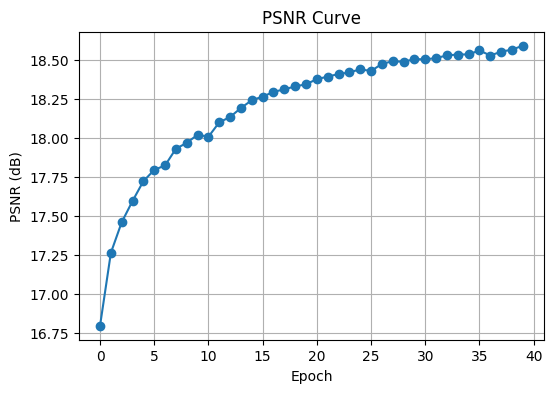

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(psnr_list, marker='o')
plt.xlabel("Epoch")
plt.ylabel("PSNR (dB)")
plt.title("PSNR Curve")
plt.grid(True)
plt.show()

##### Images

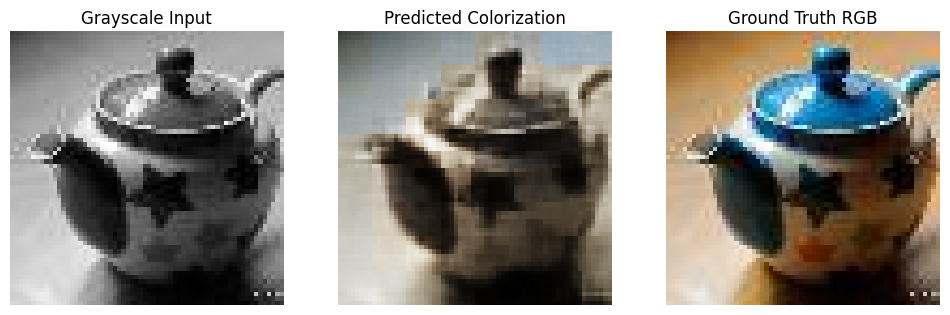

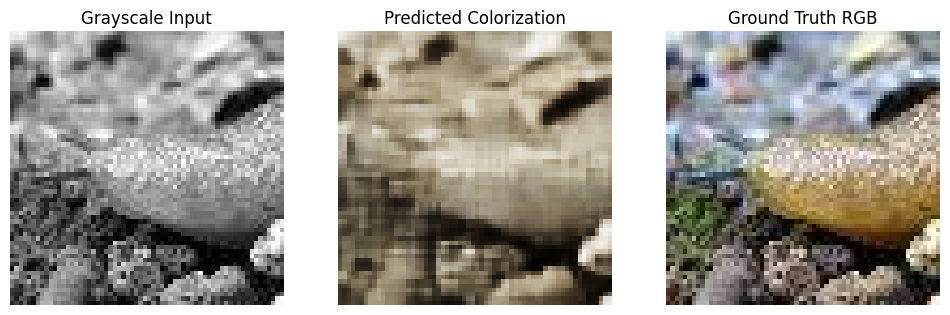

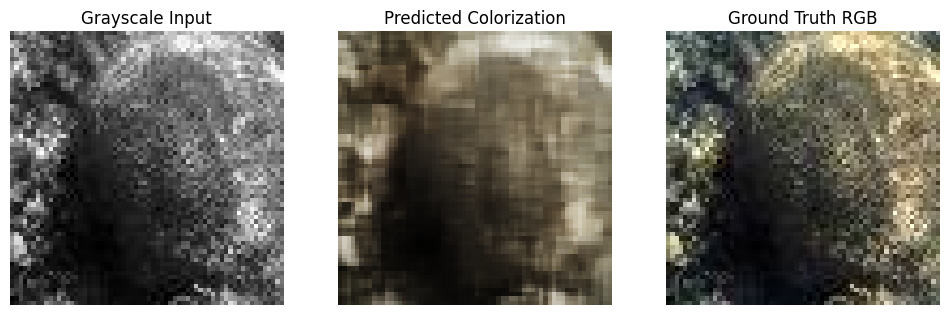

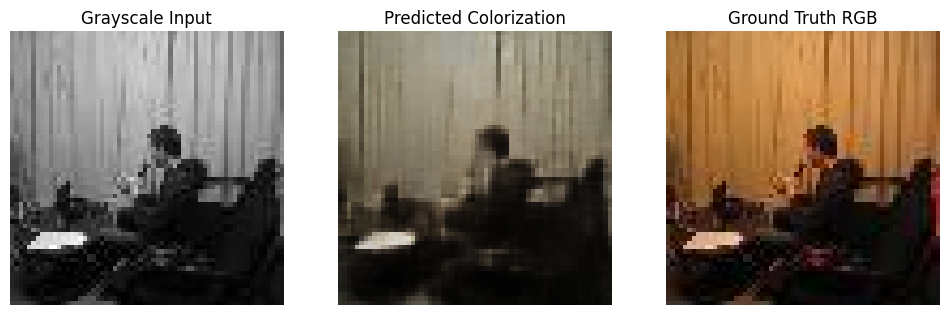

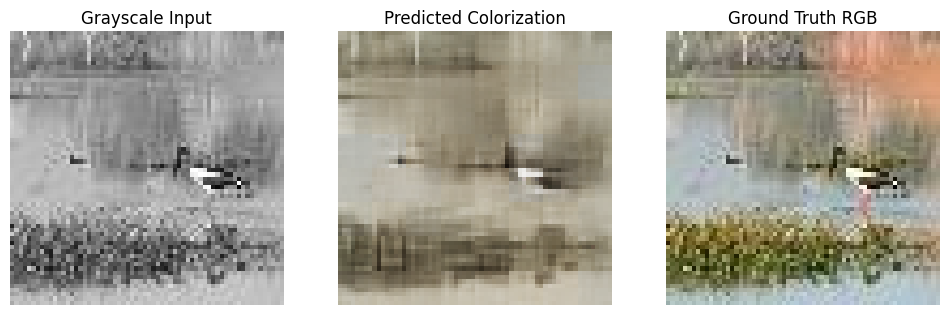

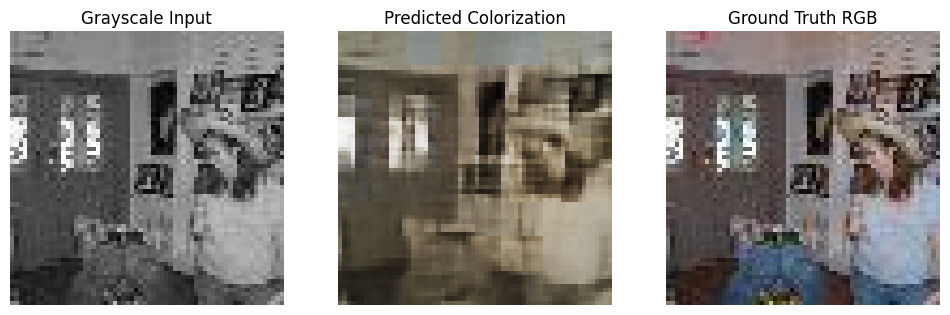

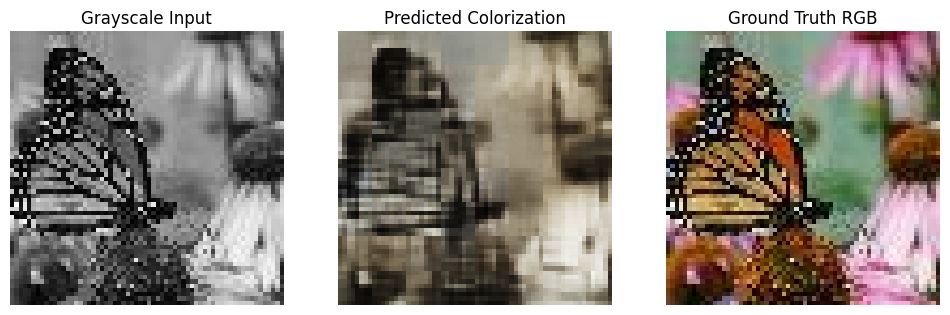

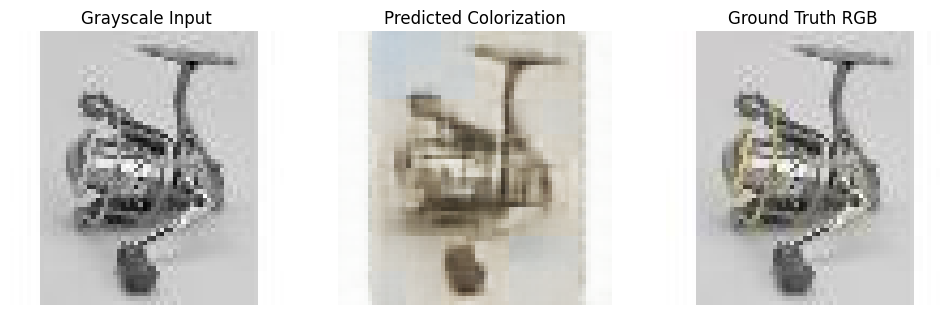

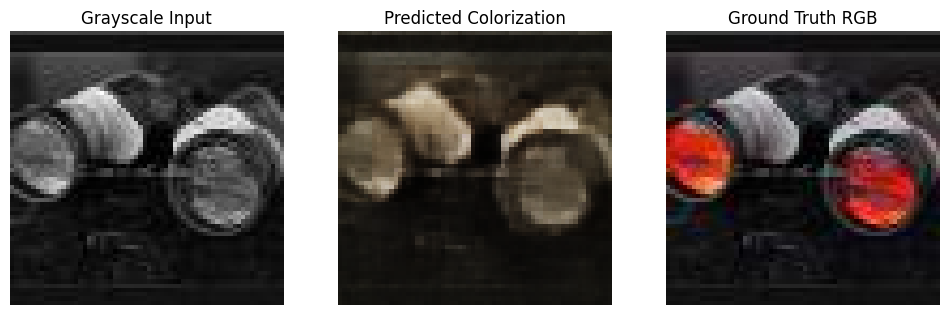

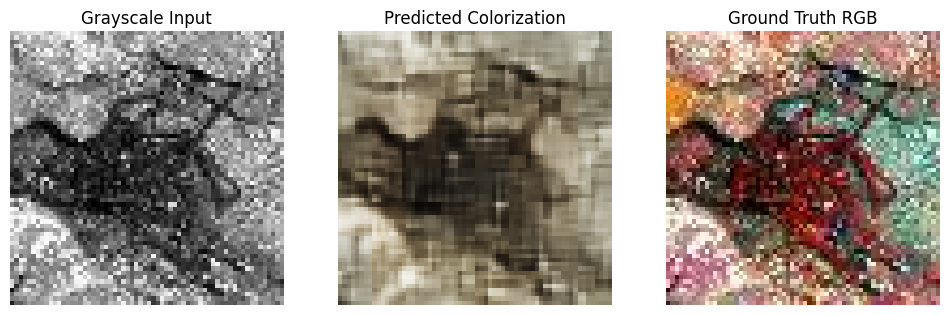

In [ ]:
def visualize_colorization(gray, pred, rgb):
    gray = gray[0].cpu().squeeze().numpy()
    pred = pred[0].cpu().permute(1,2,0).numpy()
    rgb  = rgb[0].cpu().permute(1,2,0).numpy()

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.title("Grayscale Input"); plt.imshow(gray, cmap="gray"); plt.axis("off")
    plt.subplot(1,3,2); plt.title("Predicted Colorization"); plt.imshow(pred); plt.axis("off")
    plt.subplot(1,3,3); plt.title("Ground Truth RGB"); plt.imshow(rgb); plt.axis("off")
    plt.show()

# Example visualization
baseline.eval()

# randomly pick 10 indices
indices = random.sample(range(len(val_dataset)), 10)

for idx in indices:
    gray, rgb = val_dataset[idx]   # get one sample from validation dataset

    # Add batch dimension (1, C, H, W)
    gray = gray.unsqueeze(0).to(device)
    rgb  = rgb.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = baseline(gray)

    visualize_colorization(gray, pred, rgb)

## 9.0 Apply U-Net Model
We adopt a UNet-style encoder–decoder architecture with skip connections
to better preserve spatial structure and recover color details.

## 9.1 Build U-Net

In [ ]:
class UNetColor(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.middle = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU(),
            nn.Conv2d(64, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 3, 3, padding=1), nn.Sigmoid()  # Output RGB
        )

    def forward(self, x):
        e = self.encoder(x)
        m = self.middle(e)
        d = self.decoder(m)
        return d

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
def compute_metrics(pred, target):
    """
    pred   : (B,3,H,W)  predicted RGB
    target : (B,3,H,W)  ground truth RGB
    """

    # SSIM (higher = better)
    ssim_score = ssim(pred, target, data_range=1.0, size_average=True)

    # PSNR (higher = better)
    mse = F.mse_loss(pred, target)
    psnr_score = -10 * torch.log10(mse)

    return ssim_score.item(), psnr_score.item()

### 9.1.1 MSE Loss to train

In [ ]:
%%time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Dataset Sampling ----
train_dataset_full = ColorizationDataset(train_dir)
indices = random.sample(range(len(train_dataset_full)), 100000) # 100000
train_dataset = Subset(train_dataset_full, indices)

val_dataset_full = ColorizationDataset(val_dir)
indices = random.sample(range(len(val_dataset_full)), 1000) # 1000/10000
val_dataset = Subset(val_dataset_full, indices)

test_dataset_full = ColorizationDataset(test_dir)
indices = random.sample(range(len(test_dataset_full)), 1000) # 1000/10000
test_dataset = Subset(test_dataset_full, indices)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False)

# ---- Define U-Net model + loss + optimizer ----
model = UNetColor().to(device)

criterion = nn.MSELoss()   # training loss = MSE
l1_metric = nn.L1Loss()    # validation metric L1

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 20

train_loss_list = []
val_mse_list = []
val_l1_list = []
ssim_list = []
psnr_list = []

# ---- Step 3: track best SSIM ----
best_ssim = -1
best_epoch = 0

for epoch in range(epochs):

    # ---- Training ----
    model.train()
    train_loss = 0

    for gray, rgb in train_loader:
        gray = gray.to(device)
        rgb  = rgb.to(device)

        pred = model(gray)
        loss = criterion(pred, rgb)  # training = MSE

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # ---- Validation ----
    model.eval()
    val_mse = 0
    val_l1  = 0
    val_ssim = 0
    val_psnr = 0

    with torch.no_grad():
        for gray, rgb in val_loader:
            gray = gray.to(device)
            rgb  = rgb.to(device)

            pred = model(gray)

            # MSE validation
            mse = criterion(pred, rgb)
            val_mse += mse.item()

            # L1 validation
            l1 = l1_metric(pred, rgb)
            val_l1 += l1.item()

            # perceptual metrics
            s, p = compute_metrics(pred, rgb)
            val_ssim += s
            val_psnr += p

    # ---- Average losses & metrics ----
    train_loss /= len(train_loader)
    val_mse    /= len(val_loader)
    val_l1     /= len(val_loader)
    val_ssim   /= len(val_loader)
    val_psnr   /= len(val_loader)

    print(
        f"[U-Net - MSE Train] Epoch {epoch+1}/{epochs} | "
        f"Train MSE: {train_loss:.4f} | "
        f"Val MSE: {val_mse:.4f} | "
        f"Val L1: {val_l1:.4f} | "
        f"SSIM: {val_ssim:.4f} | PSNR: {val_psnr:.2f} dB"
    )

    # ---- Step 3: save best checkpoint (validation SSIM criterion) ----
    if val_ssim > best_ssim:
        best_ssim = val_ssim
        best_epoch = epoch + 1
        torch.save(model.state_dict(), "best_unet_mse_ssim.pth")
        print(f"🔥 New best MSE-trained model saved at epoch {epoch+1} (SSIM={val_ssim:.4f})")

    # ---- Record values ----
    train_loss_list.append(train_loss)
    val_mse_list.append(val_mse)
    val_l1_list.append(val_l1)
    ssim_list.append(val_ssim)
    psnr_list.append(val_psnr)

print(f"\n✔ Training finished — best epoch = {best_epoch}, best SSIM = {best_ssim:.4f}")

[U-Net - MSE Train] Epoch 1/20 | Train MSE: 0.0130 | Val MSE: 0.0100 | Val L1: 0.0667 | SSIM: 0.8764 | PSNR: 20.33 dB
🔥 New best MSE-trained model saved at epoch 1 (SSIM=0.8764)
[U-Net - MSE Train] Epoch 2/20 | Train MSE: 0.0095 | Val MSE: 0.0089 | Val L1: 0.0600 | SSIM: 0.9148 | PSNR: 20.98 dB
🔥 New best MSE-trained model saved at epoch 2 (SSIM=0.9148)
[U-Net - MSE Train] Epoch 3/20 | Train MSE: 0.0088 | Val MSE: 0.0086 | Val L1: 0.0603 | SSIM: 0.9231 | PSNR: 21.04 dB
🔥 New best MSE-trained model saved at epoch 3 (SSIM=0.9231)
[U-Net - MSE Train] Epoch 4/20 | Train MSE: 0.0085 | Val MSE: 0.0083 | Val L1: 0.0578 | SSIM: 0.9261 | PSNR: 21.26 dB
🔥 New best MSE-trained model saved at epoch 4 (SSIM=0.9261)
[U-Net - MSE Train] Epoch 5/20 | Train MSE: 0.0084 | Val MSE: 0.0083 | Val L1: 0.0578 | SSIM: 0.9293 | PSNR: 21.23 dB
🔥 New best MSE-trained model saved at epoch 5 (SSIM=0.9293)
[U-Net - MSE Train] Epoch 6/20 | Train MSE: 0.0083 | Val MSE: 0.0083 | Val L1: 0.0581 | SSIM: 0.9291 | PSNR: 2

In [ ]:
# ====== Load best saved checkpoint ======
best_model = UNetColor().to(device)
best_model.load_state_dict(torch.load("best_unet_mse_ssim.pth"))
best_model.eval()

print("✔ Best SSIM MSE-trained model loaded for testing!")

# ====== Define metrics ======
test_mse  = 0
test_l1   = 0
test_ssim = 0
test_psnr = 0

with torch.no_grad():
    for gray, rgb in test_loader:
        gray = gray.to(device)
        rgb  = rgb.to(device)

        pred = best_model(gray)

        # Numeric metrics
        test_mse  += criterion(pred, rgb).item()
        test_l1   += l1_metric(pred, rgb).item()

        # Perceptual metrics
        s, p = compute_metrics(pred, rgb)
        test_ssim += s
        test_psnr += p

# ---- Averaging ----
test_mse  /= len(test_loader)
test_l1   /= len(test_loader)
test_ssim /= len(test_loader)
test_psnr /= len(test_loader)

print("\n🔹 FINAL TEST RESULTS (Best MSE-Trained U-Net) 🔹")
print("-------------------------------------------------")
print(f"Test MSE  = {test_mse:.6f}")
print(f"Test L1   = {test_l1:.6f}")
print(f"Test SSIM = {test_ssim:.4f}")
print(f"Test PSNR = {test_psnr:.2f} dB")
print("-------------------------------------------------\n")

✔ Best SSIM MSE-trained model loaded for testing!

🔹 FINAL TEST RESULTS (Best MSE-Trained U-Net) 🔹
-------------------------------------------------
Test MSE  = 0.007858
Test L1   = 0.055793
Test SSIM = 0.9320
Test PSNR = 21.51 dB
-------------------------------------------------



In [ ]:
# Test metrics: MSE, L1, SSIM, PSNR
##########################
unet_mse_mse  = test_mse
unet_mse_l1  = test_l1
unet_mse_ssim = test_ssim
unet_mse_psnr   = test_psnr
##########################

#### Visualization

##### Train vs Validation Loss Curve (MSE and L1)

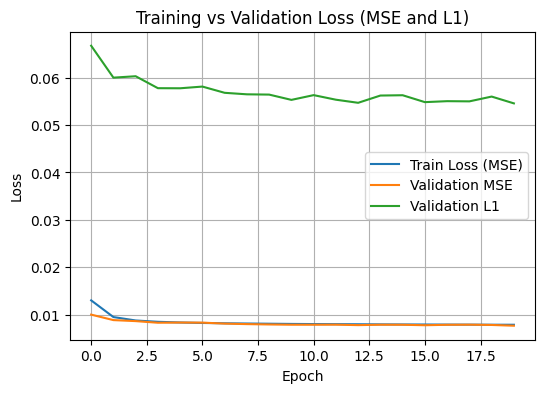

In [ ]:
plt.figure(figsize=(6,4))

plt.plot(train_loss_list, label="Train Loss (MSE)")
plt.plot(val_mse_list, label="Validation MSE")
plt.plot(val_l1_list, label="Validation L1")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (MSE and L1)")
plt.legend()
plt.grid(True)
plt.show()

##### SSIM Curve

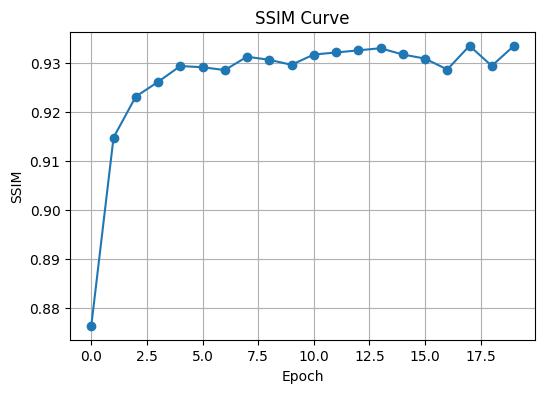

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(ssim_list, marker='o')
plt.xlabel("Epoch")
plt.ylabel("SSIM")
plt.title("SSIM Curve")
plt.grid(True)
plt.show()

##### PSNR Curve

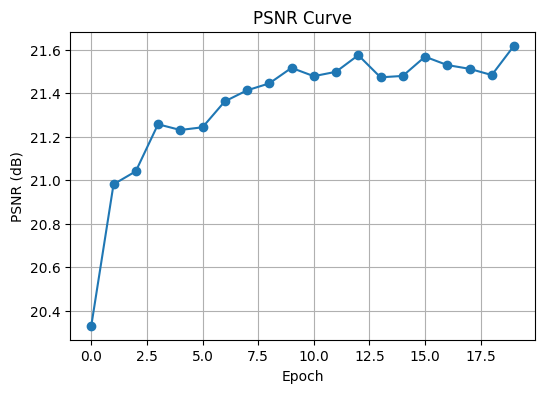

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(psnr_list, marker='o')
plt.xlabel("Epoch")
plt.ylabel("PSNR (dB)")
plt.title("PSNR Curve")
plt.grid(True)
plt.show()

##### Images

In [ ]:
def visualize_colorization(gray, pred, rgb):
    """
    gray: (1,1,H,W) grayscale image
    pred: (1,3,H,W) predicted RGB
    rgb : (1,3,H,W) ground truth RGB
    """

    gray = gray[0].cpu().squeeze().numpy()
    pred = pred[0].cpu().permute(1,2,0).numpy()
    rgb  = rgb[0].cpu().permute(1,2,0).numpy()

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.title("Grayscale Input")
    plt.imshow(gray, cmap="gray")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Predicted Colorization")
    plt.imshow(pred)
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Ground Truth RGB")
    plt.imshow(rgb)
    plt.axis("off")

    plt.show()

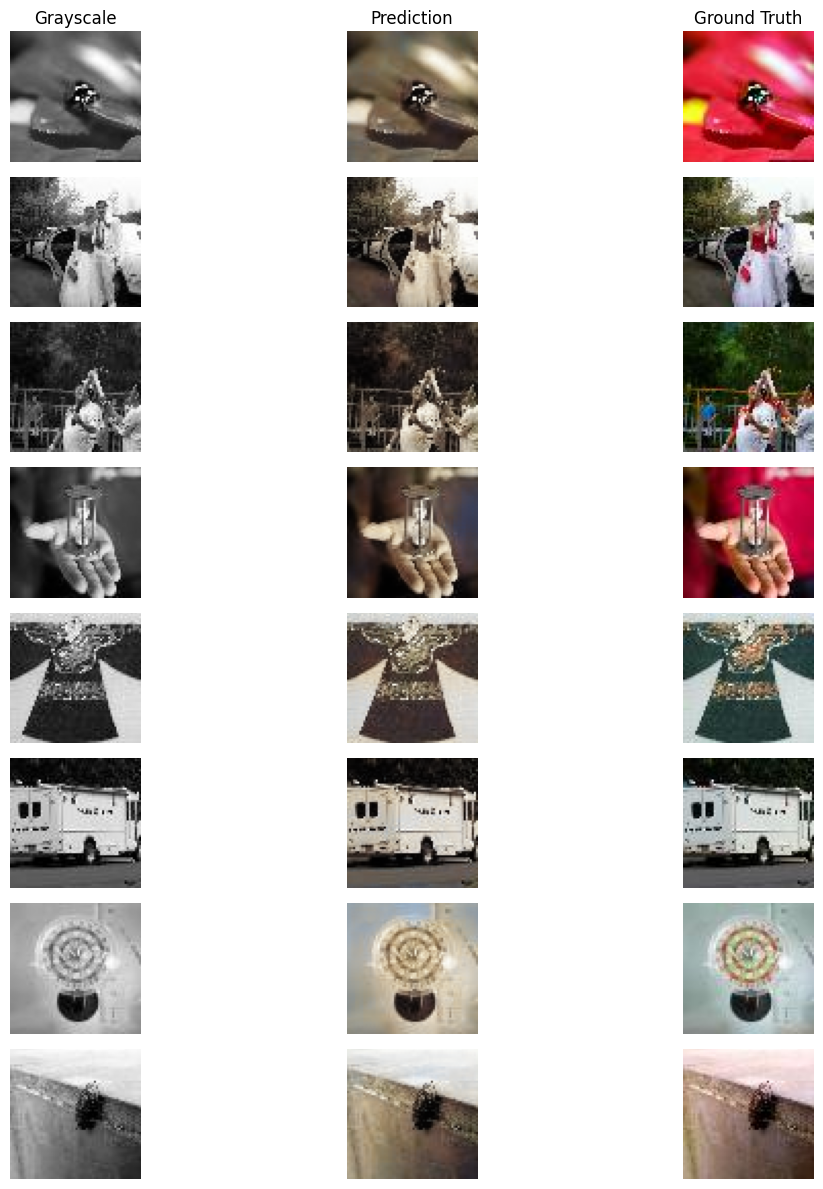

In [ ]:
# get a batch
gray_batch, rgb_batch = next(iter(val_loader))

gray_batch = gray_batch.to(device)
rgb_batch  = rgb_batch.to(device)

with torch.no_grad():
    pred_batch = model(gray_batch)

batch_size = gray_batch.size(0)   # usually 8
num_show = min(batch_size, 10)    # safety check

plt.figure(figsize=(12, 1.5 * num_show))

for i in range(num_show):
    gray = gray_batch[i].cpu().squeeze().numpy()
    pred = pred_batch[i].cpu().permute(1,2,0).numpy()
    rgb  = rgb_batch[i].cpu().permute(1,2,0).numpy()

    plt.subplot(num_show, 3, 3*i+1)
    plt.imshow(gray, cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.title("Grayscale")

    plt.subplot(num_show, 3, 3*i+2)
    plt.imshow(pred)
    plt.axis("off")
    if i == 0:
        plt.title("Prediction")

    plt.subplot(num_show, 3, 3*i+3)
    plt.imshow(rgb)
    plt.axis("off")
    if i == 0:
        plt.title("Ground Truth")

plt.tight_layout()
plt.show()

### 9.1.2 L1 Loss to train

In [ ]:
%%time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Dataset Sampling ----
train_dataset_full = ColorizationDataset(train_dir)
indices = random.sample(range(len(train_dataset_full)), 100000) # 100000
train_dataset = Subset(train_dataset_full, indices)

val_dataset_full = ColorizationDataset(val_dir)
indices = random.sample(range(len(val_dataset_full)), 1000) # 1000/10000
val_dataset = Subset(val_dataset_full, indices)

test_dataset_full = ColorizationDataset(test_dir)
indices = random.sample(range(len(test_dataset_full)), 1000) # 1000/10000
test_dataset = Subset(test_dataset_full, indices)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False)

# ---- Define U-Net, Loss, Optimizer ----
model = UNetColor().to(device)

criterion = nn.L1Loss()     # training loss = L1
mse_metric = nn.MSELoss()   # validation metric

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 20

train_loss_list = []
val_l1_list = []
val_mse_list = []
ssim_list = []
psnr_list = []

# ---- Step 3: track best model on validation SSIM ----
best_ssim = -1
best_epoch = 0

for epoch in range(epochs):

    # ---- Training ----
    model.train()
    train_loss = 0

    for gray, rgb in train_loader:
        gray = gray.to(device)
        rgb  = rgb.to(device)

        pred = model(gray)
        loss = criterion(pred, rgb)  # train = L1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # ---- Validation ----
    model.eval()
    val_l1  = 0
    val_mse = 0
    val_ssim = 0
    val_psnr = 0

    with torch.no_grad():
        for gray, rgb in val_loader:
            gray = gray.to(device)
            rgb  = rgb.to(device)

            pred = model(gray)

            # Validation L1
            l1 = criterion(pred, rgb)
            val_l1 += l1.item()

            # Validation MSE
            mse = mse_metric(pred, rgb)
            val_mse += mse.item()

            # perceptual measures
            s, p = compute_metrics(pred, rgb)
            val_ssim += s
            val_psnr += p

    # ---- Average ----
    train_loss /= len(train_loader)
    val_l1     /= len(val_loader)
    val_mse    /= len(val_loader)
    val_ssim   /= len(val_loader)
    val_psnr   /= len(val_loader)

    # ---- Print ----
    print(
        f"[U-Net L1 Train] Epoch {epoch+1}/{epochs} | "
        f"Train L1: {train_loss:.4f} | "
        f"Val L1: {val_l1:.4f} | "
        f"Val MSE: {val_mse:.4f} | "
        f"SSIM: {val_ssim:.4f} | PSNR: {val_psnr:.2f} dB"
    )

    # ---- Step 3: save best model checkpoint based on SSIM ----
    if val_ssim > best_ssim:
        best_ssim = val_ssim
        best_epoch = epoch + 1
        torch.save(model.state_dict(), "best_unet_l1_ssim.pth")
        print(f"🔥 Saved new best L1-trained model at epoch {best_epoch} (SSIM={best_ssim:.4f})")

    # ---- Record for plotting ----
    train_loss_list.append(train_loss)
    val_l1_list.append(val_l1)
    val_mse_list.append(val_mse)
    ssim_list.append(val_ssim)
    psnr_list.append(val_psnr)

print(f"\n✔ Training complete. Best epoch = {best_epoch}, Best SSIM = {best_ssim:.4f}")

[U-Net L1 Train] Epoch 1/20 | Train L1: 0.0781 | Val L1: 0.0683 | Val MSE: 0.0109 | SSIM: 0.8718 | PSNR: 19.98 dB
🔥 Saved new best L1-trained model at epoch 1 (SSIM=0.8718)
[U-Net L1 Train] Epoch 2/20 | Train L1: 0.0643 | Val L1: 0.0627 | Val MSE: 0.0097 | SSIM: 0.9122 | PSNR: 20.63 dB
🔥 Saved new best L1-trained model at epoch 2 (SSIM=0.9122)
[U-Net L1 Train] Epoch 3/20 | Train L1: 0.0602 | Val L1: 0.0618 | Val MSE: 0.0097 | SSIM: 0.9207 | PSNR: 20.64 dB
🔥 Saved new best L1-trained model at epoch 3 (SSIM=0.9207)
[U-Net L1 Train] Epoch 4/20 | Train L1: 0.0585 | Val L1: 0.0594 | Val MSE: 0.0094 | SSIM: 0.9280 | PSNR: 20.81 dB
🔥 Saved new best L1-trained model at epoch 4 (SSIM=0.9280)
[U-Net L1 Train] Epoch 5/20 | Train L1: 0.0576 | Val L1: 0.0583 | Val MSE: 0.0092 | SSIM: 0.9297 | PSNR: 20.95 dB
🔥 Saved new best L1-trained model at epoch 5 (SSIM=0.9297)
[U-Net L1 Train] Epoch 6/20 | Train L1: 0.0570 | Val L1: 0.0577 | Val MSE: 0.0091 | SSIM: 0.9335 | PSNR: 20.99 dB
🔥 Saved new best L1-t

In [ ]:
# ====== Load test set ======
test_dataset_full = ColorizationDataset(test_dir)
test_loader = DataLoader(test_dataset_full, batch_size=8, shuffle=False)

# ====== Load best saved checkpoint ======
best_model = UNetColor().to(device)
best_model.load_state_dict(torch.load("best_unet_l1_ssim.pth"))
best_model.eval()

print("✔ Best SSIM L1-trained model loaded for testing!\n")

# ====== Define metrics ======
test_l1   = 0
test_mse  = 0
test_ssim = 0
test_psnr = 0

with torch.no_grad():
    for gray, rgb in test_loader:
        gray = gray.to(device)
        rgb  = rgb.to(device)

        pred = best_model(gray)

        # Reconstruction metrics
        test_l1  += criterion(pred, rgb).item()
        test_mse += mse_metric(pred, rgb).item()

        # Perceptual metrics
        s, p = compute_metrics(pred, rgb)
        test_ssim += s
        test_psnr += p

# ---- Averages ----
test_l1   /= len(test_loader)
test_mse  /= len(test_loader)
test_ssim /= len(test_loader)
test_psnr /= len(test_loader)

print("🔹 FINAL TEST RESULTS (Best L1-Trained U-Net) 🔹")
print("-------------------------------------------------")
print(f"Test L1   = {test_l1:.6f}")
print(f"Test MSE  = {test_mse:.6f}")
print(f"Test SSIM = {test_ssim:.4f}")
print(f"Test PSNR = {test_psnr:.2f} dB")
print("-------------------------------------------------\n")

✔ Best SSIM L1-trained model loaded for testing!

🔹 FINAL TEST RESULTS (Best L1-Trained U-Net) 🔹
-------------------------------------------------
Test L1   = 0.055431
Test MSE  = 0.008083
Test SSIM = 0.9371
Test PSNR = 21.48 dB
-------------------------------------------------



In [ ]:
# Test metrics: MSE, L1, SSIM, PSNR
##########################
unet_l1_mse  = test_mse
unet_l1_l1  = test_l1
unet_l1_ssim = test_ssim
unet_l1_psnr = test_psnr
##########################

#### Visualization

##### Train vs Validation Loss Curve (MSE and L1)

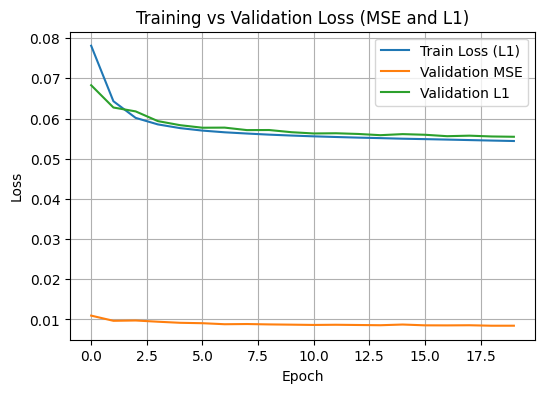

In [ ]:
plt.figure(figsize=(6,4))

plt.plot(train_loss_list, label="Train Loss (L1)")
plt.plot(val_mse_list, label="Validation MSE")
plt.plot(val_l1_list, label="Validation L1")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (MSE and L1)")
plt.legend()
plt.grid(True)
plt.show()

##### SSIM Curve

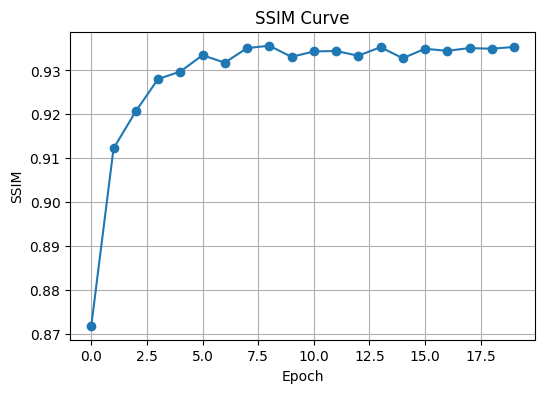

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(ssim_list, marker='o')
plt.xlabel("Epoch")
plt.ylabel("SSIM")
plt.title("SSIM Curve")
plt.grid(True)
plt.show()

##### PSNR Curve

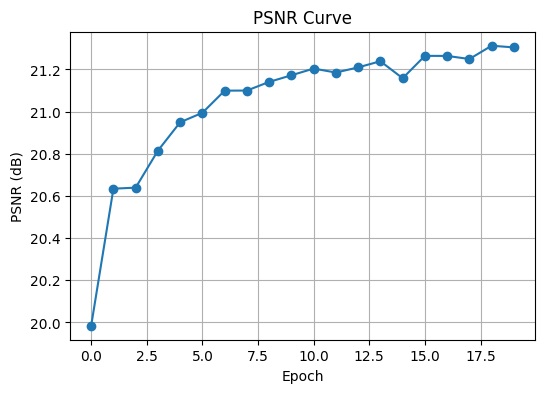

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(psnr_list, marker='o')
plt.xlabel("Epoch")
plt.ylabel("PSNR (dB)")
plt.title("PSNR Curve")
plt.grid(True)
plt.show()

##### Images

In [ ]:
def visualize_colorization(gray, pred, rgb):
    """
    gray: (1,1,H,W) grayscale image
    pred: (1,3,H,W) predicted RGB
    rgb : (1,3,H,W) ground truth RGB
    """

    gray = gray[0].cpu().squeeze().numpy()
    pred = pred[0].cpu().permute(1,2,0).numpy()
    rgb  = rgb[0].cpu().permute(1,2,0).numpy()

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.title("Grayscale Input")
    plt.imshow(gray, cmap="gray")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Predicted Colorization")
    plt.imshow(pred)
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Ground Truth RGB")
    plt.imshow(rgb)
    plt.axis("off")

    plt.show()

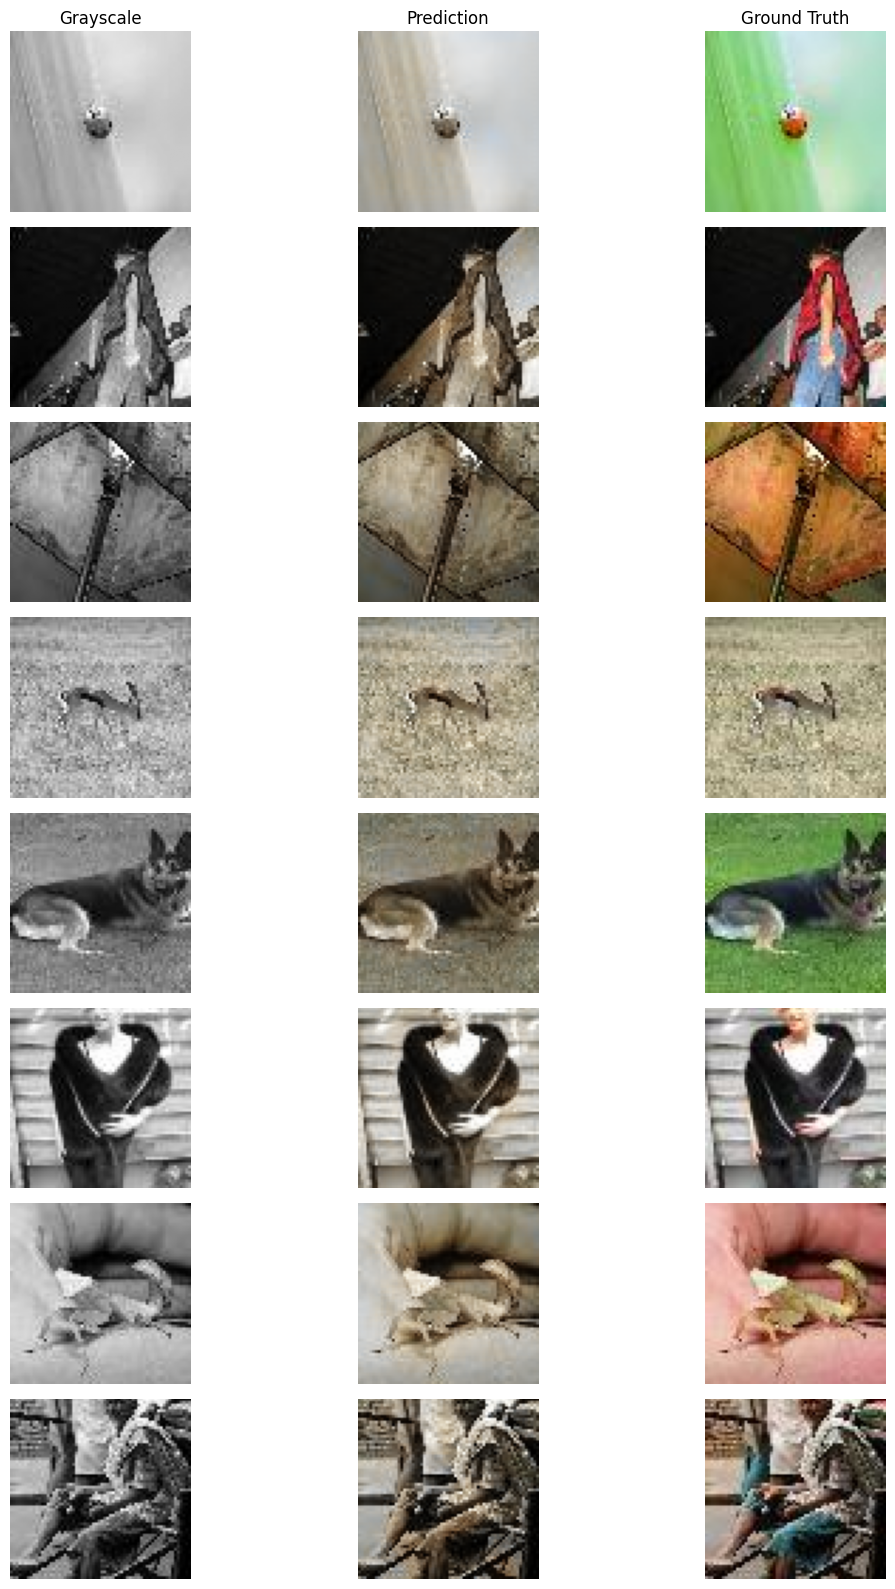

In [ ]:
# get 1 batch
gray_batch, rgb_batch = next(iter(val_loader))

gray_batch = gray_batch.to(device)
rgb_batch  = rgb_batch.to(device)

with torch.no_grad():
    pred_batch = model(gray_batch)

# determine how many images to show (max 10 but cannot exceed batch size)
num_show = min(10, gray_batch.size(0))

plt.figure(figsize=(12, num_show * 2))

for i in range(num_show):
    gray = gray_batch[i].cpu().squeeze().numpy()
    pred = pred_batch[i].cpu().permute(1,2,0).numpy()
    rgb  = rgb_batch[i].cpu().permute(1,2,0).numpy()

    plt.subplot(num_show, 3, 3*i+1)
    plt.imshow(gray, cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.title("Grayscale")

    plt.subplot(num_show, 3, 3*i+2)
    plt.imshow(pred)
    plt.axis("off")
    if i == 0:
        plt.title("Prediction")

    plt.subplot(num_show, 3, 3*i+3)
    plt.imshow(rgb)
    plt.axis("off")
    if i == 0:
        plt.title("Ground Truth")

plt.tight_layout()
plt.show()

### 9.1.3 Hybrid Loss to train

In [ ]:
%%time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Dataset Sampling ----
train_dataset_full = ColorizationDataset(train_dir)
indices = random.sample(range(len(train_dataset_full)), 100000) # 100000
train_dataset = Subset(train_dataset_full, indices)

val_dataset_full = ColorizationDataset(val_dir)
indices = random.sample(range(len(val_dataset_full)), 1000) # 1000/10000
val_dataset = Subset(val_dataset_full, indices)

test_dataset_full = ColorizationDataset(test_dir)
indices = random.sample(range(len(test_dataset_full)), 1000) # 1000/10000
test_dataset = Subset(test_dataset_full, indices)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False)

# ---- Define U-Net model ----
model = UNetColor().to(device)

# ---- Hybrid Loss Components ----
criterion_l1  = nn.L1Loss()
criterion_mse = nn.MSELoss()
alpha, beta   = 0.8, 0.2  # weighting ratio

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 20

train_loss_list = []
val_hybrid_list = []
val_mse_list = []
val_l1_list = []
ssim_list = []
psnr_list = []

# ---- Step 3: best checkpoint tracking ----
best_ssim = -1
best_epoch = 0

for epoch in range(epochs):

    # ---- Training ----
    model.train()
    train_loss = 0

    for gray, rgb in train_loader:
        gray = gray.to(device)
        rgb  = rgb.to(device)

        pred = model(gray)

        # Hybrid training loss
        loss_l1  = criterion_l1(pred, rgb)
        loss_mse = criterion_mse(pred, rgb)
        loss     = alpha * loss_l1 + beta * loss_mse

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # ---- Validation ----
    model.eval()
    val_hybrid = 0
    val_mse = 0
    val_l1  = 0
    val_ssim = 0
    val_psnr = 0

    with torch.no_grad():
        for gray, rgb in val_loader:
            gray = gray.to(device)
            rgb  = rgb.to(device)

            pred = model(gray)

            # Hybrid validation loss
            loss_l1_val  = criterion_l1(pred, rgb)
            loss_mse_val = criterion_mse(pred, rgb)
            hybrid_loss  = alpha * loss_l1_val + beta * loss_mse_val

            val_hybrid += hybrid_loss.item()

            # Separate validation metrics
            val_l1  += loss_l1_val.item()
            val_mse += loss_mse_val.item()

            # SSIM & PSNR
            s, p = compute_metrics(pred, rgb)
            val_ssim += s
            val_psnr += p

    # ---- Average losses & metrics ----
    train_loss /= len(train_loader)
    val_hybrid /= len(val_loader)
    val_l1     /= len(val_loader)
    val_mse    /= len(val_loader)
    val_ssim   /= len(val_loader)
    val_psnr   /= len(val_loader)

    print(
        f"[U-Net Hybrid] Epoch {epoch+1}/{epochs} | "
        f"Train Hybrid: {train_loss:.4f} | "
        f"Val Hybrid: {val_hybrid:.4f} | "
        f"Val L1: {val_l1:.4f} | "
        f"Val MSE: {val_mse:.4f} | "
        f"SSIM: {val_ssim:.4f} | "
        f"PSNR: {val_psnr:.2f} dB"
    )

    # ---- Step 3: save best checkpoint based on SSIM ----
    if val_ssim > best_ssim:
        best_ssim = val_ssim
        best_epoch = epoch + 1
        torch.save(model.state_dict(), "best_unet_hybrid_ssim.pth")
        print(f"🔥 Saved new best hybrid model (epoch {best_epoch}, SSIM={best_ssim:.4f})")

    # ---- Store for plotting ----
    train_loss_list.append(train_loss)
    val_hybrid_list.append(val_hybrid)
    val_l1_list.append(val_l1)
    val_mse_list.append(val_mse)
    ssim_list.append(val_ssim)
    psnr_list.append(val_psnr)

print(f"\n✔ Training complete — best epoch = {best_epoch}, best SSIM = {best_ssim:.4f}")

[U-Net Hybrid] Epoch 1/20 | Train Hybrid: 0.0648 | Val Hybrid: 0.0564 | Val L1: 0.0678 | Val MSE: 0.0106 | SSIM: 0.8663 | PSNR: 20.14 dB
🔥 Saved new best hybrid model (epoch 1, SSIM=0.8663)
[U-Net Hybrid] Epoch 2/20 | Train Hybrid: 0.0538 | Val Hybrid: 0.0513 | Val L1: 0.0617 | Val MSE: 0.0094 | SSIM: 0.9088 | PSNR: 20.82 dB
🔥 Saved new best hybrid model (epoch 2, SSIM=0.9088)
[U-Net Hybrid] Epoch 3/20 | Train Hybrid: 0.0497 | Val Hybrid: 0.0486 | Val L1: 0.0586 | Val MSE: 0.0090 | SSIM: 0.9245 | PSNR: 21.07 dB
🔥 Saved new best hybrid model (epoch 3, SSIM=0.9245)
[U-Net Hybrid] Epoch 4/20 | Train Hybrid: 0.0484 | Val Hybrid: 0.0479 | Val L1: 0.0577 | Val MSE: 0.0087 | SSIM: 0.9283 | PSNR: 21.22 dB
🔥 Saved new best hybrid model (epoch 4, SSIM=0.9283)
[U-Net Hybrid] Epoch 5/20 | Train Hybrid: 0.0476 | Val Hybrid: 0.0474 | Val L1: 0.0570 | Val MSE: 0.0087 | SSIM: 0.9300 | PSNR: 21.23 dB
🔥 Saved new best hybrid model (epoch 5, SSIM=0.9300)
[U-Net Hybrid] Epoch 6/20 | Train Hybrid: 0.0471 |

In [ ]:
# ====== Load test set ======
test_dataset_full = ColorizationDataset(test_dir)
test_loader = DataLoader(test_dataset_full, batch_size=8, shuffle=False)

# ====== Load best saved checkpoint ======
best_model = UNetColor().to(device)
best_model.load_state_dict(torch.load("best_unet_hybrid_ssim.pth"))
best_model.eval()

print("✔ Best hybrid SSIM-based model loaded for testing!\n")

# ====== Define evaluation metric objects ======
test_l1   = 0
test_mse  = 0
test_ssim = 0
test_psnr = 0

with torch.no_grad():
    for gray, rgb in test_loader:
        gray = gray.to(device)
        rgb  = rgb.to(device)

        pred = best_model(gray)

        # Reconstruction accuracy metrics
        test_l1  += criterion_l1(pred, rgb).item()
        test_mse += criterion_mse(pred, rgb).item()

        # perceptual metrics
        s, p = compute_metrics(pred, rgb)
        test_ssim += s
        test_psnr += p

# ---- Average ----
test_l1   /= len(test_loader)
test_mse  /= len(test_loader)
test_ssim /= len(test_loader)
test_psnr /= len(test_loader)

print("🔹 FINAL TEST RESULTS — Best Hybrid-trained U-Net 🔹")
print("-------------------------------------------------")
print(f"Test L1   = {test_l1:.6f}")
print(f"Test MSE  = {test_mse:.6f}")
print(f"Test SSIM = {test_ssim:.4f}")
print(f"Test PSNR = {test_psnr:.2f} dB")
print("-------------------------------------------------\n")

✔ Best hybrid SSIM-based model loaded for testing!

🔹 FINAL TEST RESULTS — Best Hybrid-trained U-Net 🔹
-------------------------------------------------
Test L1   = 0.054121
Test MSE  = 0.007893
Test SSIM = 0.9387
Test PSNR = 21.59 dB
-------------------------------------------------



In [ ]:
# Test metrics: MSE, L1, SSIM, PSNR
##########################
unet_hybrid_mse = test_mse
unet_hybrid_l1  = test_l1
unet_hybrid_ssim = test_ssim
unet_hybrid_psnr = test_psnr
##########################

#### Visualization

##### Train vs Validation Loss Curve

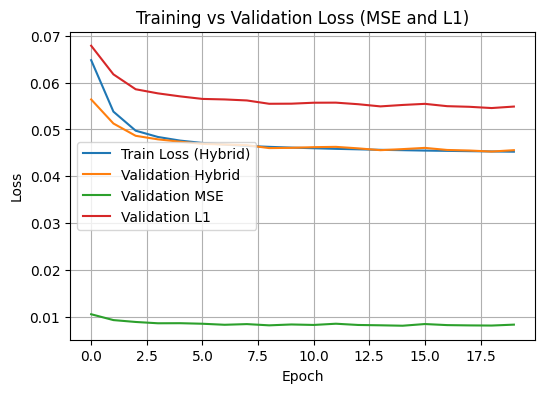

In [ ]:
plt.figure(figsize=(6,4))

plt.plot(train_loss_list, label="Train Loss (Hybrid)")
plt.plot(val_hybrid_list, label="Validation Hybrid")
plt.plot(val_mse_list, label="Validation MSE")
plt.plot(val_l1_list, label="Validation L1")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (MSE and L1)")
plt.legend()
plt.grid(True)
plt.show()

##### SSIM Curve

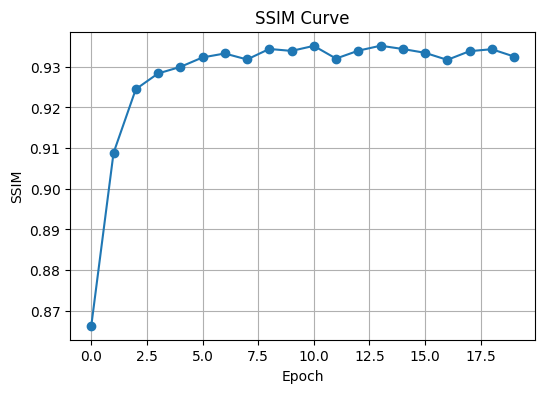

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(ssim_list, marker='o')
plt.xlabel("Epoch")
plt.ylabel("SSIM")
plt.title("SSIM Curve")
plt.grid(True)
plt.show()

##### PSNR Curve

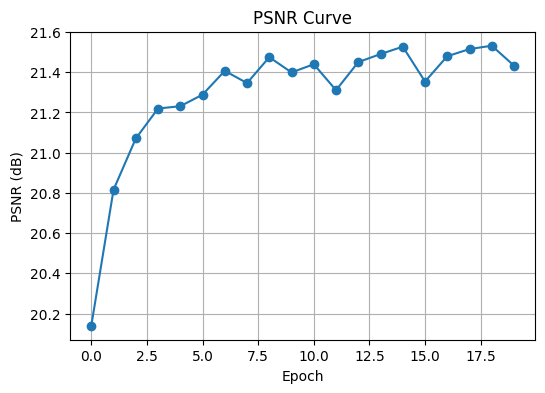

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(psnr_list, marker='o')
plt.xlabel("Epoch")
plt.ylabel("PSNR (dB)")
plt.title("PSNR Curve")
plt.grid(True)
plt.show()